# Classification of Damage in ExperimentalPipes

This program reads the data from a number of damaged state trials of both finite element models (FEMs) and physical experiments. 
The database of model results is populated by the original signal responses from the model for a number of transducer array locations. The program generates white noise of user-specified properties and time-averages the the noisy responses.
The database of physical experimental results is populated by signal responses picked up by a bus-powered USB. Environmental white noise is a natural inclusion of the signal in this case; therefore a number of trace responses are populated into the database for time-averaging.
All of the trials are marked by their states of damage, and the type of damage variation is specified by the user. Principal Component Analysis (PCA) is used to reduce the dimensionality of the data and clearly present the relation of the damaged state with the PCs. Machine Learning via Support Vector Machines (SVM) is used to determine the optimal number of PCs. It may also be used to classify the data through application of feature extraction methods.

## User Inputs

All of the data is stored in an excel file in which waveguide material properties, crack geometry, FEM mesh, transducer specifications, and other such parameters are identified for each signal. The signals in this file have a sampling frequency of 100 kSa/s and duration of 5 ms. Specify this excel file under filename.

In [78]:
# Stored Data
filename = 'G:/My Drive/USGW Research/Programming/Damage Database/Signals.xlsx'

# Parameters
Pipe_model     = 'Comsol 5.3a Model'
Pipe_physical  = 'Pipe 4'

# Material Properties
Elasticity  = 'Viscoelastic'
Modulus     = 1.1      # GPa
Poissons    = 0.45     # microstrains/microstrains
Density     = 945      # kg/m^3

# Crack Geometry
Orientation   = 90;      # degrees
Location      = 235;     # mm
Depth         = 21;      # mm
Length        = 2*Depth; # mm
Width         = 10;      # mm
Circumference = 'Outside'

# Mesh
meshmax     = 15;      # mm
meshmin     = 0.5;     # mm
timestep    = 0.01;   # ms

# Transducers
StrainCoefficient = 'd33'
PZTType_model     = 'Point'
PZTType_physical  = 'Piezo-Disc'
Arrays            = ['A','A\'','R\'','R'];
Axes              = [2,4];

# Artificially generated white noise
mean = 0;
std  = 5e-4;

# All variables are frozen except one
variable = 'Depth (mm)'

# Storage of Analysis Results
parent    = 'G:/My Drive/USGW Research/Programming/Git Practice/Ultrasonic-Guided-Waves-in-Polyethylene-Pipes'
directory = 'Depth Damaged States (Outer Circumference, Perp Orientation, Short Axial Length, 10 mm Width)'

## Import Necessary Modules and Functions

In [31]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import math
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
import pickle
from PIL import Image
from scipy.fft import fft, ifft
from scipy import signal
import pywt
# install lvm-read

Add text and color:

In [32]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

Obtain the frequency domains of all the signals in the dataframe in the form of the Single-Sided Amplitude Spectrums:

In [33]:
def ssas (Fs, time_domain):
    (L,n) = np.shape(time_domain)                # size of the time domain database (number of signals x number of samples)
    T = 1/Fs                                     # Sampling period
    t = np.arange(0,duration+T,T)                # zeroed time axis in seconds
    
    # Power Spectrum
    Y = []
    i = 0
    for index, row in time_domain.iterrows():
        Y.append(fft(row.values))
        i = i + 1
        
    # Normalized magnitude of the power spectrum
    P2 = []
    P1 = []
    i = 0

    while i < L:
        p2                   = abs(Y[i]);              # Double-sided Amplitude Spectrum
        p1                   = p2[0:math.ceil(n/2)];
        p1[1:math.ceil(n/2)] = 2*p1[1:math.ceil(n/2)]; # Single-sided Amplitude Spectrum
        i = i + 1;

        P2.append(p2)
        P1.append(p1)
    
    # Frequency domain dataframe
    f = Fs*list(range(0,math.ceil(n/2)))/n;     # Frequency Axis
    P1 = pd.DataFrame(P1)
    freq_dom_title = []
    for freq in f:
        freq_dom_title.append('Frequency Domain (Hz)')

    header = [freq_dom_title, f]
    P1 = pd.DataFrame(P1)
    P1.columns = header
    
    return P1

Plot all frequency domains on the same grid and color-vode them by damaged state:

In [34]:
def freq_domains_by_ds(freq_bins, colors_dict, transparency, df, grouping_category, title):
    
    # freq_bins is a list of floats, colors_dict is a dictionary with ints for keys and colors string for items, 
    # transparency is a float, df is a pandas dataframe, and grouping_category is a string
    
    # df has frequency attributes that may be extracted using extract_freq_bins
    
#     plt.axis('on')
    fig, ax = plt.subplots(figsize = (15,10))

    grouped = df.groupby(grouping_category)

    for freq in freq_bins:
        x1 = np.ones(len(df.index))
        x1 = x1*freq
        df['Frequency (Hz)'] = x1
        for key, group in grouped:
            group.plot(ax=ax, kind='scatter', x=freq, y=df[freq], alpha = transparency, color=colors[key])
    
    plt.legend(colors_dict.keys());
    ax.set_ylabel('Single Sided Amplitude Spectrum', fontsize = 15)
    ax.set_xlabel('Frequency (Hz)', fontsize = 15)    
    ax.set_title(title, fontsize = 20)
#     fig.suptitle('Frequency Domain Response by Damaged State',fontsize = 15)
    plt.grid(which='major', linestyle='-')    
    plt.show()
    
#     df = df.drop('Frequency (Hz)', axis=1)
        
    return fig, ax

Run a preliminary PCA which reduces the dataset from a high-order number of variables to 2 PCs. This function provides the explained variance, plots the components on a coordinate grid, and presents teh expleained variance vs number of components:

In [35]:
def prePCA (freq_data):
    pca = RandomizedPCA(n_components=2)
    pca.fit(freq_data)
    freq_data_pca = pca.transform(freq_data)
    print("original shape:   ", freq_data.shape)
    print("transformed shape:", freq_data_pca.shape)
    label = "Variance explained by each principal component \nPC1: " + str(pca.explained_variance_ratio_[0]) + ' \nPC2: '+ str(pca.explained_variance_ratio_[1])
    print(label)
    
    fig, ax = plt.subplots(2,figsize=(10,10))
    
    comps = pca.components_
    ax[0].scatter(freq_data_pca[:,0],freq_data_pca[:,1])
    ax[0].set_xlabel('Component 1')
    ax[0].set_ylabel('Component 2');
    
    pca = RandomizedPCA().fit(freq_data)
    ax[1].plot(np.cumsum(pca.explained_variance_ratio_))
    ax[1].set_xlabel('Number of components')
    ax[1].set_ylabel('Cumulative explained variance');
    
    ax[1].text(0, 1, label)
    
    return pca, comps, freq_data_pca

Categorize train and test data using SVM. This code uses the grid-search method to optimize the number of PCs. Hyperparameter tuning is employed to run multiple trials and compare accuracies to a subset of trained data.

In [36]:
def pca_svm (n_components):
    pca = RandomizedPCA(n_components)
    pca.fit(x)
    # pca.transform(x)
    svc = SVC(kernel='rbf')
    basemodel = make_pipeline(pca, svc)
    
    param_grid = {'svc__C': np.logspace(np.log10(0.001), np.log10(20), num=200),
                  'svc__gamma': ['auto']}
    grid = GridSearchCV(basemodel, param_grid, cv = 5, n_jobs = 2, verbose = 0)
    lab_enc = preprocessing.LabelEncoder()
    ytrain_encoded = lab_enc.fit_transform(ytrain)
    ytest_encoded = lab_enc.fit_transform(ytest)
    grid.fit(Xtrain, ytrain_encoded)

    svc_model = grid.best_estimator_
    yfit = svc_model.predict(Xtest)
    classification = classification_report(ytest_encoded, yfit)
    accuacy = accuracy_score(ytest_encoded, yfit)
    
    freq_data_pca = pca.transform(x)
    return classification, accuacy, freq_data_pca, svc_model

This is the testing dataset's accuracy. To get the training dataset's accuracy, just replace Xtest with Xtrain. We're expecting testing accuracy to be lower if we have a much bigger starting database size, but in this case both the testing and training data accuracies are good characterizations of the model's accuracy. If both datasets provide a good accuracy, overfitting may not be a problem.

## Point to Directory

In [79]:
cwd = os.getcwd
print(os.getcwd())

G:\My Drive\USGW Research\Programming\Git Practice\Ultrasonic-Guided-Waves-in-Polyethylene-Pipes\Depth Damaged States (Outer Circumference, Perp Orientation, Short Axial Length, 10 mm Width)


In [80]:
os.chdir(parent)

## Initialize Data Matrices

The user-specified filepath above must be .xlsx

The data incorporated within the database includes interval data representing the time-domains of the response signals, the single-sided amplitude spectrum over a specified frequency range, details on the transducers and crack orientations, information on the pipe and geometries, and other such data.

In [81]:
sheetname = '10 kHz 100 kSa-s 5 ms'
damage    = pd.read_excel(filename, sheetname, header = [0,1]);
damage.head(10)

Pipe                                           \
         Designation Elasticity Modulus (GPa) Poisson's Ratio   
0  Comsol 5.3a Model    Elastic           1.1            0.45   
1  Comsol 5.3a Model    Elastic           1.1            0.45   
2  Comsol 5.3a Model    Elastic           1.1            0.45   
3  Comsol 5.3a Model    Elastic           1.1            0.45   
4  Comsol 5.3a Model    Elastic           1.1            0.45   
5  Comsol 5.3a Model    Elastic           1.1            0.45   
6  Comsol 5.3a Model    Elastic           1.1            0.45   
7  Comsol 5.3a Model    Elastic           1.1            0.45   
8  Comsol 5.3a Model    Elastic           1.1            0.45   
9  Comsol 5.3a Model    Elastic           1.1            0.45   

                    Transducer                                   \
  Density (kg/m^3) Designation Axis Strain Coefficient PZT Type   
0              945           A  1.0                d33    Point   
1              945           A  2.0                d33    Point   
2              945           A  3.0                d33    Point   
3              945           A  4.0                d33    Point   
4              945           A  1.5                d33    Point   
5              945           A  2.5                d33    Point   
6              945           A  3.5                d33    Point   
7              945           A  4.5                d33    Point   
8              945          A'  1.0                d33    Point   
9              945          A'  2.0                d33    Point   

                  Mesh  ... Time Domain (ms)                                \
  Max Edge Length (mm)  ...             4.91      4.92      4.93      4.94   
0                   15  ...         0.000012 -0.000113 -0.000202 -0.000208   
1                   15  ...        -0.000134 -0.000142 -0.000110 -0.000035   
2                   15  ...        -0.000103 -0.000213 -0.000260 -0.000214   
3                   15  ...         0.000185 -0.000053 -0.000281 -0.000396   
4                   15  ...        -0.000404 -0.001937 -0.003141 -0.003529   
5                   15  ...        -0.000397 -0.001853 -0.003100 -0.003550   
6                   15  ...        -0.000812 -0.002212 -0.003251 -0.003457   
7                   15  ...        -0.000884 -0.002268 -0.003310 -0.003512   
8                   15  ...        -0.016894 -0.022624 -0.020388 -0.010845   
9                   15  ...        -0.015941 -0.022084 -0.020559 -0.011807   

                                                               
       4.95      4.96      4.97      4.98      4.99         5  
0 -0.000116  0.000047  0.000227  0.000362  0.000408  0.000352  
1  0.000072  0.000186  0.000278  0.000320  0.000297  0.000208  
2 -0.000083  0.000089  0.000242  0.000323  0.000309  0.000209  
3 -0.000343 -0.000144  0.000122  0.000352  0.000463  0.000422  
4 -0.002902  0.001397  0.000892  0.002835  0.004254  0.004648  
5 -0.002944 -0.001379  0.000761  0.002819  0.004252  0.004644  
6 -0.002660 -0.001025  0.001021  0.002886  0.004062  0.004225  
7 -0.002713  0.001083  0.001013  0.002901  0.004108  0.004268  
8  0.002548  0.014823  0.021428  0.020023  0.011392 -0.000907  
9  0.001015  0.013210  0.020338  0.019946  0.012490  0.001093  

[10 rows x 520 columns]

In [82]:
damage

Pipe                                              \
            Designation    Elasticity Modulus (GPa) Poisson's Ratio   
0     Comsol 5.3a Model       Elastic           1.1            0.45   
1     Comsol 5.3a Model       Elastic           1.1            0.45   
2     Comsol 5.3a Model       Elastic           1.1            0.45   
3     Comsol 5.3a Model       Elastic           1.1            0.45   
4     Comsol 5.3a Model       Elastic           1.1            0.45   
...                 ...           ...           ...             ...   
3904             Pipe 4  Viscoelastic             -               -   
3905             Pipe 4  Viscoelastic             -               -   
3906             Pipe 4  Viscoelastic             -               -   
3907             Pipe 4  Viscoelastic             -               -   
3908             Pipe 6  Viscoelastic          4.15             0.4   

                       Transducer                                      \
     Density (kg/m^3) Designation Axis Strain Coefficient    PZT Type   
0                 945           A  1.0                d33       Point   
1                 945           A  2.0                d33       Point   
2                 945           A  3.0                d33       Point   
3                 945           A  4.0                d33       Point   
4                 945           A  1.5                d33       Point   
...               ...         ...  ...                ...         ...   
3904                -           A  2.0                d33  Piezo-Disc   
3905                -          A'  2.0                d33  Piezo-Disc   
3906                -          R'  2.0                d33  Piezo-Disc   
3907                -           R  2.0                d33  Piezo-Disc   
3908             1400         NaN  NaN                NaN         NaN   

                     Mesh  ... Time Domain (ms)                                \
     Max Edge Length (mm)  ...             4.91      4.92      4.93      4.94   
0                      15  ...         0.000012 -0.000113 -0.000202 -0.000208   
1                      15  ...        -0.000134 -0.000142 -0.000110 -0.000035   
2                      15  ...        -0.000103 -0.000213 -0.000260 -0.000214   
3                      15  ...         0.000185 -0.000053 -0.000281 -0.000396   
4                      15  ...        -0.000404 -0.001937 -0.003141 -0.003529   
...                   ...  ...              ...       ...       ...       ...   
3904                    -  ...        -0.000445 -0.000550 -0.000342 -0.000509   
3905                    -  ...         0.000041 -0.000013 -0.000020  0.000060   
3906                    -  ...        -0.000308 -0.000233 -0.000218 -0.000236   
3907                    -  ...        -0.000317 -0.000322 -0.000238 -0.000181   
3908                    -  ...              NaN       NaN       NaN       NaN   

                                                                  
          4.95      4.96      4.97      4.98      4.99         5  
0    -0.000116  0.000047  0.000227  0.000362  0.000408  0.000352  
1     0.000072  0.000186  0.000278  0.000320  0.000297  0.000208  
2    -0.000083  0.000089  0.000242  0.000323  0.000309  0.000209  
3    -0.000343 -0.000144  0.000122  0.000352  0.000463  0.000422  
4    -0.002902  0.001397  0.000892  0.002835  0.004254  0.004648  
...        ...       ...       ...       ...       ...       ...  
3904 -0.000435 -0.000486 -0.000350 -0.000323 -0.000382 -0.000417  
3905  0.000153  0.000032  0.000146  0.000146  0.000091 -0.000009  
3906 -0.000112 -0.000181 -0.000198 -0.000158 -0.000142 -0.000079  
3907 -0.000268 -0.000323 -0.000364 -0.000226 -0.000252 -0.000268  
3908       NaN       NaN       NaN       NaN       NaN       NaN  

[3909 rows x 520 columns]

Extract the signal's discrete time axis:

In [83]:
time = np.array(damage['Time Domain (ms)'].columns)

Zoom in only on one part of the time domain (0-3 ms in this case)

In [84]:
for timestamp in time:
    if (timestamp >= 3.00):
        # print(timestamp in damage['Time Domain (ms)'].columns)
        damage = damage.drop(timestamp, axis=1, level = 1)

time = np.array(damage['Time Domain (ms)'].columns)

np.shape(damage)

(3909, 319)

## Data Processing

Elaborate definiations for visualization:

In [85]:
if StrainCoefficient == 'd33':
    disps = 'Radial Displacements'
elif StrainCoefficient == 'd31':
    disps = 'Axial Displacements'

### Parameter Dictionaries

In [86]:
mat_props = {}

mat_props['Elasticity']       = Elasticity;
mat_props['Modulus (GPa)']    = Modulus;
mat_props['Poisson\'s Ratio'] = Poissons;
mat_props['Density (kg/m^3)'] = Density

mat_props

{'Elasticity': 'Viscoelastic',
 'Modulus (GPa)': 1.1,
 "Poisson's Ratio": 0.45,
 'Density (kg/m^3)': 945}

In [87]:
crack_geom = {}

crack_geom['Circumference']         = Circumference;
crack_geom['Axial Location (mm)']   = Location;
crack_geom['Orientation (degrees)'] = Orientation;
crack_geom['Depth (mm)']            = Depth;
crack_geom['Length (mm)']           = Length;
crack_geom['Thickness (mm)']        = Width;

crack_geom

{'Circumference': 'Outside',
 'Axial Location (mm)': 235,
 'Orientation (degrees)': 90,
 'Depth (mm)': 21,
 'Length (mm)': 42,
 'Thickness (mm)': 10}

In [88]:
transducer = {}

transducer['Strain Coefficient'] = StrainCoefficient
transducer['Model Type']         = PZTType_model
transducer['Physical Type']      = PZTType_physical

transducer

{'Strain Coefficient': 'd33',
 'Model Type': 'Point',
 'Physical Type': 'Piezo-Disc'}

### Boolean Markers

In [89]:
mat_props_params  = list(mat_props.keys())
crack_geom_params = list(crack_geom.keys())
intervals_params  = list(intervals.keys())

In [90]:
is_pipe       = damage['Pipe','Designation']               == Pipe_physical
is_sc         = damage['Transducer','Strain Coefficient']  == StrainCoefficient
is_pzttype    = damage['Transducer','PZT Type']            == PZTType_physical

### Undamaged State

The undamaged state sees no variability in the parameters simply because it's a single state. Therefore, highlight this state by specifying no crack and the user-defined material, ultrasonic, and interval paramters above.

In [91]:
is_undamaged  = damage['Crack Properties','Depth (mm)']   == 0; # ie no crack

undamaged = damage[is_pipe & is_sc & is_pzttype]
undamaged = undamaged[is_undamaged]
    
undamaged

C:\Users\WEISUN~1\AppData\Local\Temp/ipykernel_7448/2040055641.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  undamaged = undamaged[is_undamaged]


Pipe                                                               \
     Designation    Elasticity Modulus (GPa) Poisson's Ratio Density (kg/m^3)   
3632      Pipe 4  Viscoelastic             -               -                -   
3633      Pipe 4  Viscoelastic             -               -                -   
3634      Pipe 4  Viscoelastic             -               -                -   
3635      Pipe 4  Viscoelastic             -               -                -   
3636      Pipe 4  Viscoelastic             -               -                -   
...          ...           ...           ...             ...              ...   
3719      Pipe 4  Viscoelastic             -               -                -   
3720      Pipe 4  Viscoelastic             -               -                -   
3721      Pipe 4  Viscoelastic             -               -                -   
3722      Pipe 4  Viscoelastic             -               -                -   
3723      Pipe 4  Viscoelastic             -               -                -   

      Transducer                                                     Mesh  \
     Designation Axis Strain Coefficient    PZT Type Max Edge Length (mm)   
3632           A  2.0                d33  Piezo-Disc                    -   
3633          A'  2.0                d33  Piezo-Disc                    -   
3634          R'  2.0                d33  Piezo-Disc                    -   
3635           R  2.0                d33  Piezo-Disc                    -   
3636           A  2.0                d33  Piezo-Disc                    -   
...          ...  ...                ...         ...                  ...   
3719           R  2.0                d33  Piezo-Disc                    -   
3720           A  2.0                d33  Piezo-Disc                    -   
3721          A'  2.0                d33  Piezo-Disc                    -   
3722          R'  2.0                d33  Piezo-Disc                    -   
3723           R  2.0                d33  Piezo-Disc                    -   

      ... Time Domain (ms)                                                    \
      ...              2.9      2.91      2.92      2.93      2.94      2.95   
3632  ...        -0.000011  0.000039 -0.000042  0.000035  0.000114  0.000012   
3633  ...         0.000039 -0.000062 -0.000143 -0.000037 -0.000188  0.000007   
3634  ...        -0.000072  0.000082  0.000007  0.000166  0.000147  0.000225   
3635  ...         0.000099 -0.000033  0.000179  0.000257  0.000375  0.000423   
3636  ...        -0.000095  0.000063 -0.000070 -0.000220 -0.000124 -0.000135   
...   ...              ...       ...       ...       ...       ...       ...   
3719  ...         0.000062  0.000027  0.000068  0.000105  0.000224  0.000373   
3720  ...         0.000337  0.000232  0.000341  0.000352  0.000269  0.000284   
3721  ...        -0.000056 -0.000212 -0.000264 -0.000179 -0.000058 -0.000085   
3722  ...        -0.000051 -0.000085 -0.000058  0.000059  0.000039  0.000135   
3723  ...         0.000080  0.000076  0.000129  0.000139  0.000258  0.000307   

                                              
          2.96      2.97      2.98      2.99  
3632 -0.000032 -0.000050 -0.000140 -0.000044  
3633  0.000061  0.000141  0.000171  0.000148  
3634  0.000158  0.000169  0.000054  0.000019  
3635  0.000476  0.000537  0.000484  0.000496  
3636 -0.000137 -0.000092 -0.000111 -0.000043  
...        ...       ...       ...       ...  
3719  0.000341  0.000453  0.000519  0.000369  
3720  0.000383  0.000159  0.000265  0.000380  
3721  0.000063  0.000078  0.000054  0.000213  
3722  0.000001  0.000077 -0.000019 -0.000057  
3723  0.000436  0.000468  0.000421  0.000298  

[92 rows x 319 columns]

### Damaged States at the Variablity of a Single Parameter

Highlight the damaged states of interest by specifying the user-defined crack geometry, material, ultrasonic, and interval parameters above. Everything is frozen except the parameter of interest.

Exception: If the parameter of interest is the crack depth, then the crack length is also variable and vice-versa. It's unrealistic to expect that one would vary and not the other in a real-world damage scenario.

In [92]:
damaged = damage[is_pipe & is_sc & is_pzttype]
    
if variable in crack_geom_params:
    crack_geom_params.remove(variable)
    if variable == 'Depth (mm)':
        crack_geom_params.remove('Length (mm)')

for param in crack_geom_params:
    damaged = damaged[damaged['Crack Properties',param] == crack_geom[param]]

damaged

Pipe                                                               \
     Designation    Elasticity Modulus (GPa) Poisson's Ratio Density (kg/m^3)   
3724      Pipe 4  Viscoelastic             -               -                -   
3725      Pipe 4  Viscoelastic             -               -                -   
3726      Pipe 4  Viscoelastic             -               -                -   
3727      Pipe 4  Viscoelastic             -               -                -   
3728      Pipe 4  Viscoelastic             -               -                -   
...          ...           ...           ...             ...              ...   
3903      Pipe 4  Viscoelastic             -               -                -   
3904      Pipe 4  Viscoelastic             -               -                -   
3905      Pipe 4  Viscoelastic             -               -                -   
3906      Pipe 4  Viscoelastic             -               -                -   
3907      Pipe 4  Viscoelastic             -               -                -   

      Transducer                                                     Mesh  \
     Designation Axis Strain Coefficient    PZT Type Max Edge Length (mm)   
3724           A  2.0                d33  Piezo-Disc                    -   
3725          A'  2.0                d33  Piezo-Disc                    -   
3726          R'  2.0                d33  Piezo-Disc                    -   
3727           R  2.0                d33  Piezo-Disc                    -   
3728           A  2.0                d33  Piezo-Disc                    -   
...          ...  ...                ...         ...                  ...   
3903           R  2.0                d33  Piezo-Disc                    -   
3904           A  2.0                d33  Piezo-Disc                    -   
3905          A'  2.0                d33  Piezo-Disc                    -   
3906          R'  2.0                d33  Piezo-Disc                    -   
3907           R  2.0                d33  Piezo-Disc                    -   

      ... Time Domain (ms)                                              \
      ...              2.9      2.91      2.92          2.93      2.94   
3724  ...         0.000055  0.000130  0.000193  4.362925e-05  0.000089   
3725  ...         0.000206  0.000182  0.000038 -5.020154e-05  0.000090   
3726  ...        -0.000201 -0.000177 -0.000104 -3.963982e-06  0.000115   
3727  ...         0.000172 -0.000046 -0.000071  9.207536e-05  0.000212   
3728  ...         0.000211  0.000215  0.000080 -9.454721e-05 -0.000031   
...   ...              ...       ...       ...           ...       ...   
3903  ...         0.000105  0.000228  0.000147  2.409787e-04  0.000220   
3904  ...        -0.000008 -0.000003  0.000033 -4.101201e-07 -0.000002   
3905  ...         0.000224  0.000119  0.000065 -8.304941e-05 -0.000124   
3906  ...        -0.000181 -0.000203 -0.000095 -2.634235e-05 -0.000037   
3907  ...         0.000039  0.000037  0.000008  1.698391e-04  0.000291   

                                                        
          2.95      2.96      2.97      2.98      2.99  
3724  0.000088 -0.000020  0.000076  0.000037  0.000048  
3725  0.000056  0.000286  0.000231  0.000228  0.000310  
3726  0.000048  0.000092 -0.000012  0.000156  0.000039  
3727  0.000322  0.000325  0.000464  0.000475  0.000387  
3728 -0.000002  0.000013 -0.000031  0.000071  0.000031  
...        ...       ...       ...       ...       ...  
3903  0.000255  0.000478  0.000524  0.000522  0.000565  
3904  0.000145  0.000131  0.000027  0.000163  0.000007  
3905 -0.000140  0.000054  0.000208  0.000129  0.000304  
3906  0.000030  0.000014 -0.000102 -0.000019 -0.000017  
3907  0.000279  0.000339  0.000434  0.000399  0.000456  

[184 rows x 319 columns]

Combine the undamaged and damaged dataframes into a single dataframe. Sort the rows of the database so that the data is populated in ascending order of damaged state. Undamaged is first.

In [93]:
undamaged   = undamaged.replace({'-': -1}, regex = True)

if variable in crack_geom.keys():
    damaged = damaged.sort_values(by=[('Crack Properties',variable)])

this_damage = pd.concat([undamaged,damaged])

this_damage = this_damage.replace({-1: '-'}, regex = True)

this_damage

Pipe                                                               \
     Designation    Elasticity Modulus (GPa) Poisson's Ratio Density (kg/m^3)   
3632      Pipe 4  Viscoelastic            -1              -1               -1   
3633      Pipe 4  Viscoelastic            -1              -1               -1   
3634      Pipe 4  Viscoelastic            -1              -1               -1   
3635      Pipe 4  Viscoelastic            -1              -1               -1   
3636      Pipe 4  Viscoelastic            -1              -1               -1   
...          ...           ...           ...             ...              ...   
3844      Pipe 4  Viscoelastic             -               -                -   
3843      Pipe 4  Viscoelastic             -               -                -   
3842      Pipe 4  Viscoelastic             -               -                -   
3862      Pipe 4  Viscoelastic             -               -                -   
3907      Pipe 4  Viscoelastic             -               -                -   

      Transducer                                                     Mesh  \
     Designation Axis Strain Coefficient    PZT Type Max Edge Length (mm)   
3632           A  2.0                d33          -1                   -1   
3633          A'  2.0                d33          -1                   -1   
3634          R'  2.0                d33          -1                   -1   
3635           R  2.0                d33          -1                   -1   
3636           A  2.0                d33          -1                   -1   
...          ...  ...                ...         ...                  ...   
3844           A  2.0                d33  Piezo-Disc                    -   
3843           R  2.0                d33  Piezo-Disc                    -   
3842          R'  2.0                d33  Piezo-Disc                    -   
3862          R'  2.0                d33  Piezo-Disc                    -   
3907           R  2.0                d33  Piezo-Disc                    -   

      ... Time Domain (ms)                                                    \
      ...              2.9      2.91      2.92      2.93      2.94      2.95   
3632  ...        -0.000011  0.000039 -0.000042  0.000035  0.000114  0.000012   
3633  ...         0.000039 -0.000062 -0.000143 -0.000037 -0.000188  0.000007   
3634  ...        -0.000072  0.000082  0.000007  0.000166  0.000147  0.000225   
3635  ...         0.000099 -0.000033  0.000179  0.000257  0.000375  0.000423   
3636  ...        -0.000095  0.000063 -0.000070 -0.000220 -0.000124 -0.000135   
...   ...              ...       ...       ...       ...       ...       ...   
3844  ...        -0.000184 -0.000239 -0.000254 -0.000149 -0.000383 -0.000186   
3843  ...         0.000071  0.000102  0.000180  0.000173  0.000296  0.000334   
3842  ...        -0.000235 -0.000215 -0.000178 -0.000028 -0.000015 -0.000028   
3862  ...        -0.000116 -0.000317 -0.000120 -0.000040 -0.000107  0.000123   
3907  ...         0.000039  0.000037  0.000008  0.000170  0.000291  0.000279   

                                              
          2.96      2.97      2.98      2.99  
3632 -0.000032 -0.000050 -0.000140 -0.000044  
3633  0.000061  0.000141  0.000171  0.000148  
3634  0.000158  0.000169  0.000054  0.000019  
3635  0.000476  0.000537  0.000484  0.000496  
3636 -0.000137 -0.000092 -0.000111 -0.000043  
...        ...       ...       ...       ...  
3844 -0.000134 -0.000221 -0.000286 -0.000224  
3843  0.000350  0.000546  0.000513  0.000422  
3842 -0.000022  0.000027  0.000002 -0.000073  
3862  0.000142  0.000030 -0.000095  0.000035  
3907  0.000339  0.000434  0.000399  0.000456  

[276 rows x 319 columns]

### Single-Sided Amplitude Spectrums

In [94]:
duration = (time.transpose()[-1] - time.transpose()[0])/1000;   # total duration of signal (s)
n = len(time.transpose());                                      # total number of samples in signal (Sa)
Fs = np.array((n-1)/duration);                                  # sampling frequency of signal (Sa/s)
T  = 1/Fs;                                                      # sampling period (s)

(L,n) = np.shape(this_damage['Time Domain (ms)'])               # size of the time domain database (number of signals x number of samples)
n     = np.array(n)                                             # Python is finicky with range
t     = np.arange(0,duration+T,T)                               # zeroed time axis in seconds

In [95]:
P1 = ssas(Fs, this_damage['Time Domain (ms)'])
P1

Frequency Domain (Hz)                                                      \
             0.000000     333.333333   666.666667   1000.000000  1333.333333    
0                0.022388     0.015923     0.016710     0.017556     0.014020   
1                0.005557     0.008643     0.001370     0.002373     0.004677   
2                0.007272     0.002875     0.010554     0.010590     0.004474   
3                0.002049     0.027589     0.016115     0.020457     0.004975   
4                0.027308     0.015087     0.015267     0.009802     0.012029   
..                    ...          ...          ...          ...          ...   
271              0.122530     0.148141     0.074629     0.067874     0.045950   
272              0.013218     0.002915     0.005380     0.014108     0.011726   
273              0.010316     0.021982     0.015582     0.014955     0.000779   
274              0.007243     0.019528     0.011462     0.009337     0.005489   
275              0.003731     0.010808     0.002550     0.017704     0.011696   

                                                                      ...  \
    1666.666667  2000.000000  2333.333333  2666.666667  3000.000000   ...   
0       0.006127     0.025027     0.017322     0.010667     0.004750  ...   
1       0.009293     0.003645     0.018536     0.028694     0.007246  ...   
2       0.009962     0.017796     0.011510     0.008476     0.007337  ...   
3       0.029820     0.015273     0.020802     0.007933     0.007957  ...   
4       0.009695     0.020853     0.019062     0.012549     0.013453  ...   
..           ...          ...          ...          ...          ...  ...   
271     0.026286     0.023801     0.022401     0.017024     0.017173  ...   
272     0.027404     0.018335     0.014163     0.006607     0.008969  ...   
273     0.012281     0.015281     0.007434     0.006352     0.007627  ...   
274     0.008775     0.016857     0.010529     0.006292     0.010544  ...   
275     0.021159     0.010062     0.023160     0.007987     0.001561  ...   

                                                                      \
    46666.666667 47000.000000 47333.333333 47666.666667 48000.000000   
0       0.002560     0.002512     0.002163     0.002406     0.003379   
1       0.001966     0.000848     0.002435     0.001403     0.000798   
2       0.001757     0.004023     0.001128     0.002130     0.003731   
3       0.001081     0.000939     0.002213     0.000573     0.000861   
4       0.001170     0.000451     0.003157     0.000978     0.003236   
..           ...          ...          ...          ...          ...   
271     0.002719     0.000903     0.001466     0.002620     0.001214   
272     0.001858     0.002371     0.000764     0.000388     0.003286   
273     0.002452     0.000841     0.001119     0.001077     0.002132   
274     0.002113     0.001788     0.001194     0.001558     0.001019   
275     0.000575     0.001192     0.001831     0.002316     0.001065   

                                                                      
    48333.333333 48666.666667 49000.000000 49333.333333 49666.666667  
0       0.000548     0.002518     0.002976     0.002262     0.001376  
1       0.001379     0.001808     0.002738     0.002116     0.000532  
2       0.001378     0.001298     0.001448     0.001380     0.001839  
3       0.003564     0.000967     0.002580     0.002564     0.002448  
4       0.001363     0.002161     0.001947     0.002596     0.001869  
..           ...          ...          ...          ...          ...  
271     0.001543     0.003606     0.001949     0.002749     0.000970  
272     0.001701     0.001895     0.001625     0.002664     0.002774  
273     0.001683     0.001105     0.001553     0.001453     0.002476  
274     0.001959     0.002314     0.000585     0.001047     0.001415  
275     0.001380     0.003661     0.002259     0.002189     0.002563  

[276 rows x 150 columns]

Include the Single-Sided Amplitude Spectrum in the damage database

In [96]:
for freq in P1.columns:
    this_damage[freq] = P1[freq].values

this_damage

C:\Users\WEISUN~1\AppData\Local\Temp/ipykernel_7448/297605895.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  this_damage[freq] = P1[freq].values


Pipe                                                               \
     Designation    Elasticity Modulus (GPa) Poisson's Ratio Density (kg/m^3)   
3632      Pipe 4  Viscoelastic            -1              -1               -1   
3633      Pipe 4  Viscoelastic            -1              -1               -1   
3634      Pipe 4  Viscoelastic            -1              -1               -1   
3635      Pipe 4  Viscoelastic            -1              -1               -1   
3636      Pipe 4  Viscoelastic            -1              -1               -1   
...          ...           ...           ...             ...              ...   
3844      Pipe 4  Viscoelastic             -               -                -   
3843      Pipe 4  Viscoelastic             -               -                -   
3842      Pipe 4  Viscoelastic             -               -                -   
3862      Pipe 4  Viscoelastic             -               -                -   
3907      Pipe 4  Viscoelastic             -               -                -   

      Transducer                                                     Mesh  \
     Designation Axis Strain Coefficient    PZT Type Max Edge Length (mm)   
3632           A  2.0                d33          -1                   -1   
3633          A'  2.0                d33          -1                   -1   
3634          R'  2.0                d33          -1                   -1   
3635           R  2.0                d33          -1                   -1   
3636           A  2.0                d33          -1                   -1   
...          ...  ...                ...         ...                  ...   
3844           A  2.0                d33  Piezo-Disc                    -   
3843           R  2.0                d33  Piezo-Disc                    -   
3842          R'  2.0                d33  Piezo-Disc                    -   
3862          R'  2.0                d33  Piezo-Disc                    -   
3907           R  2.0                d33  Piezo-Disc                    -   

      ... Frequency Domain (Hz)                               \
      ...    46666.666666666664   47000.0 47333.333333333336   
3632  ...              0.002560  0.002512           0.002163   
3633  ...              0.001966  0.000848           0.002435   
3634  ...              0.001757  0.004023           0.001128   
3635  ...              0.001081  0.000939           0.002213   
3636  ...              0.001170  0.000451           0.003157   
...   ...                   ...       ...                ...   
3844  ...              0.002719  0.000903           0.001466   
3843  ...              0.001858  0.002371           0.000764   
3842  ...              0.002452  0.000841           0.001119   
3862  ...              0.002113  0.001788           0.001194   
3907  ...              0.000575  0.001192           0.001831   

                                                                         \
     47666.666666666664   48000.0 48333.333333333336 48666.666666666664   
3632           0.002406  0.003379           0.000548           0.002518   
3633           0.001403  0.000798           0.001379           0.001808   
3634           0.002130  0.003731           0.001378           0.001298   
3635           0.000573  0.000861           0.003564           0.000967   
3636           0.000978  0.003236           0.001363           0.002161   
...                 ...       ...                ...                ...   
3844           0.002620  0.001214           0.001543           0.003606   
3843           0.000388  0.003286           0.001701           0.001895   
3842           0.001077  0.002132           0.001683           0.001105   
3862           0.001558  0.001019           0.001959           0.002314   
3907           0.002316  0.001065           0.001380           0.003661   

                                                      
       49000.0 49333.333333333336 49666.666666666664  
3632  0.002976           0.002262    

### Damage Database Dictionary

Make sure all the right damaged states are present.

In [97]:
no_ds = len(this_damage['Crack Properties',variable].unique())
no_ds

3

Only the  axes specified by user. All arrays present in dataframe

In [98]:
arrays = this_damage['Transducer','Designation'].unique()
arrays

array(['A', "A'", "R'", 'R'], dtype=object)

In [99]:
damage_by_arrays = {}

for Array in arrays:
    damage_by_arrays[Array] = this_damage[(this_damage['Transducer','Designation'] == Array) & (this_damage['Transducer','Axis'].isin(Axes)) ]
    damage_by_arrays[Array] = damage_by_arrays[Array][damage_by_arrays[Array]['Crack Properties','Depth (mm)'] != 10]   # Take out the 10 mm measurement

# damage_by_arrays

In [100]:
states = damage_by_arrays[arrays[0]]['Crack Properties',variable].unique()
states

array([0, 3, 9], dtype=int64)

### Time-Averaged Signal Data

Populate a dictionary with signals at the arrays in which the noise is cancelled by averaging the signals over each damaged state. Do the same for a max signal value dictionary and a min signal value dictionary.

In [101]:
averaged_signals = {}
max_signals      = {}
min_signals      = {}
signals = damage_by_arrays

for Array in signals.keys():
    
    averaged_signals[Array] = signals[Array].groupby([signals[Array]['Crack Properties',variable],signals[Array]['Transducer','Axis']]).mean()
    max_signals[Array]      = signals[Array].groupby([signals[Array]['Crack Properties',variable],signals[Array]['Transducer','Axis']]).max()
    min_signals[Array]      = signals[Array].groupby([signals[Array]['Crack Properties',variable],signals[Array]['Transducer','Axis']]).min()
    

### Frequency Domain over all Noisy Data and Time-Averaged Data

In [102]:
for Array in signals.keys():
    P1_noisy = ssas(Fs, signals[Array]['Time Domain (ms)'])
    for freq in P1_noisy.columns:
        signals[Array][freq] = P1_noisy[freq].values

In [103]:
for Array in averaged_signals.keys():
    P1_averaged = ssas(Fs, averaged_signals[Array]['Time Domain (ms)'])
    for freq in P1_averaged.columns:
        averaged_signals[Array][freq] = P1_averaged[freq].values

## Plots

Preliminary step to define variables which highlight the damaged states and axes that will be plotted together 

In [104]:
colors = ['red','black','blue','green','purple','orange','magenta','gray']

In [105]:
# this_damage['Frequency (Hz)']
no_ds   = len(damage_by_arrays['A']['Crack Properties'][variable].unique())
no_axes = len(damage_by_arrays['A']['Transducer']['Axis'].unique())

states  = damage_by_arrays['A']['Crack Properties'][variable].unique()
axes    = damage_by_arrays['A']['Transducer']['Axis'].unique()

In [106]:
states = [states for states in states]
states

[0, 3, 9]

In [107]:
axes = [str(axes) for axes in axes]
axes

['2.0']

In [108]:
axis_color = {}
i = 0
while i < no_axes:
    axis_color[axes[i]] = colors[i]
    i = i + 1

axis_color

{'2.0': 'red'}

Save the plots in the user-specified directory above. No error is raised if the directory already exists

In [109]:
try: 
    os.mkdir(directory) 
except OSError as error: 
    print(error) 
    
path = os.path.join(directory)
os.chdir(path)

[WinError 183] Cannot create a file when that file already exists: 'Depth Damaged States (Outer Circumference, Perp Orientation, Short Axial Length, 10 mm Width)'


### Plot all Data

Label each graph by its signals' frozen parameters:

In [110]:
crack_props = ''
for crack_geom_param in crack_geom_params:
    crack_props += crack_geom_param + ': ' + str(crack_geom[crack_geom_param]) + '\n'
    
crack_props

'Circumference: Outside\nAxial Location (mm): 235\nOrientation (degrees): 90\nThickness (mm): 10\n'

In [111]:
parameters = Elasticity + '\n' + disps + '\n'

parameters

'Viscoelastic\nRadial Displacements\n'

In [112]:
savename = Pipe_physical + ' Noisy Response '
savename += '.png'
savename

'Pipe 4 Noisy Response .png'

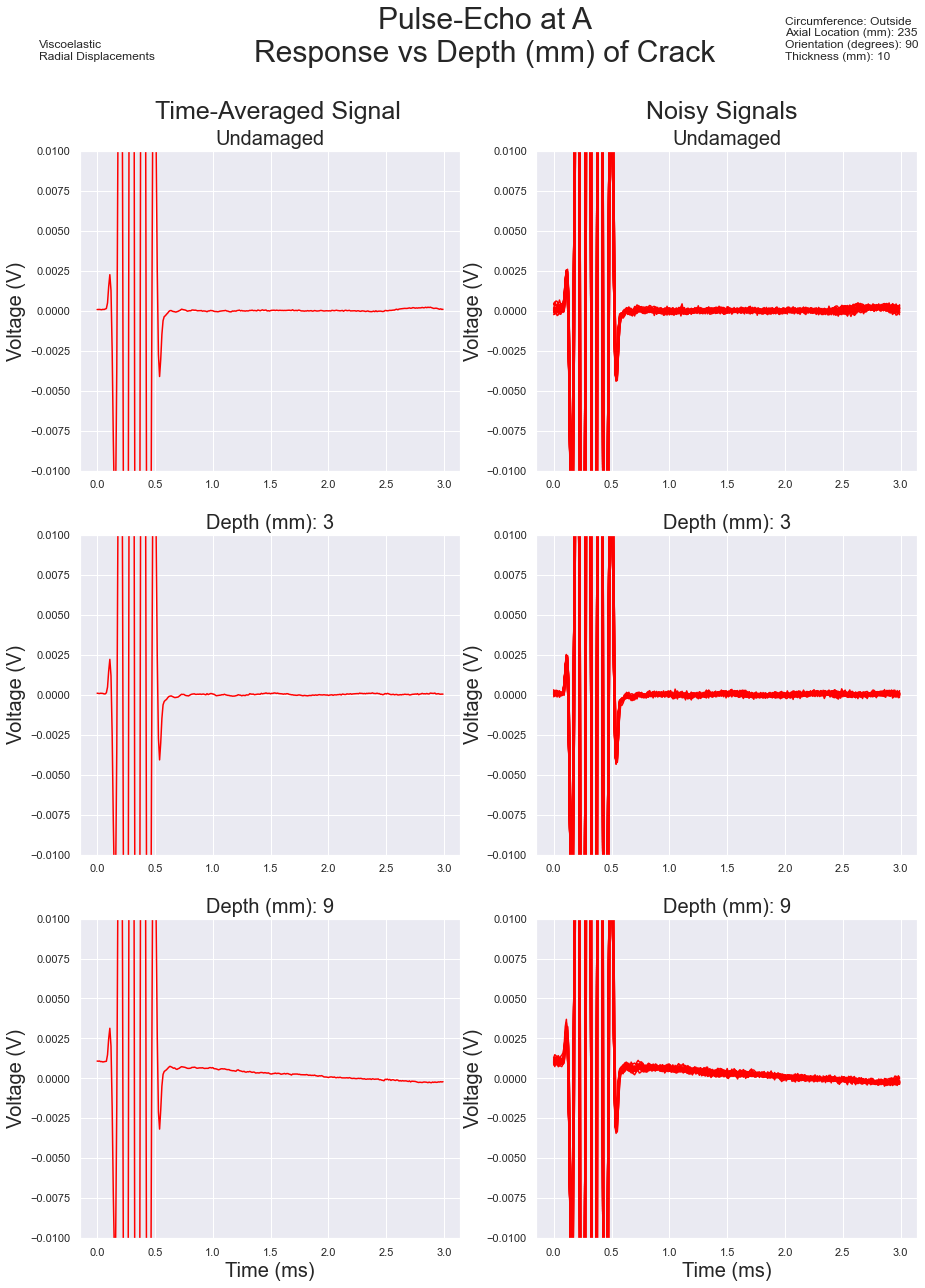

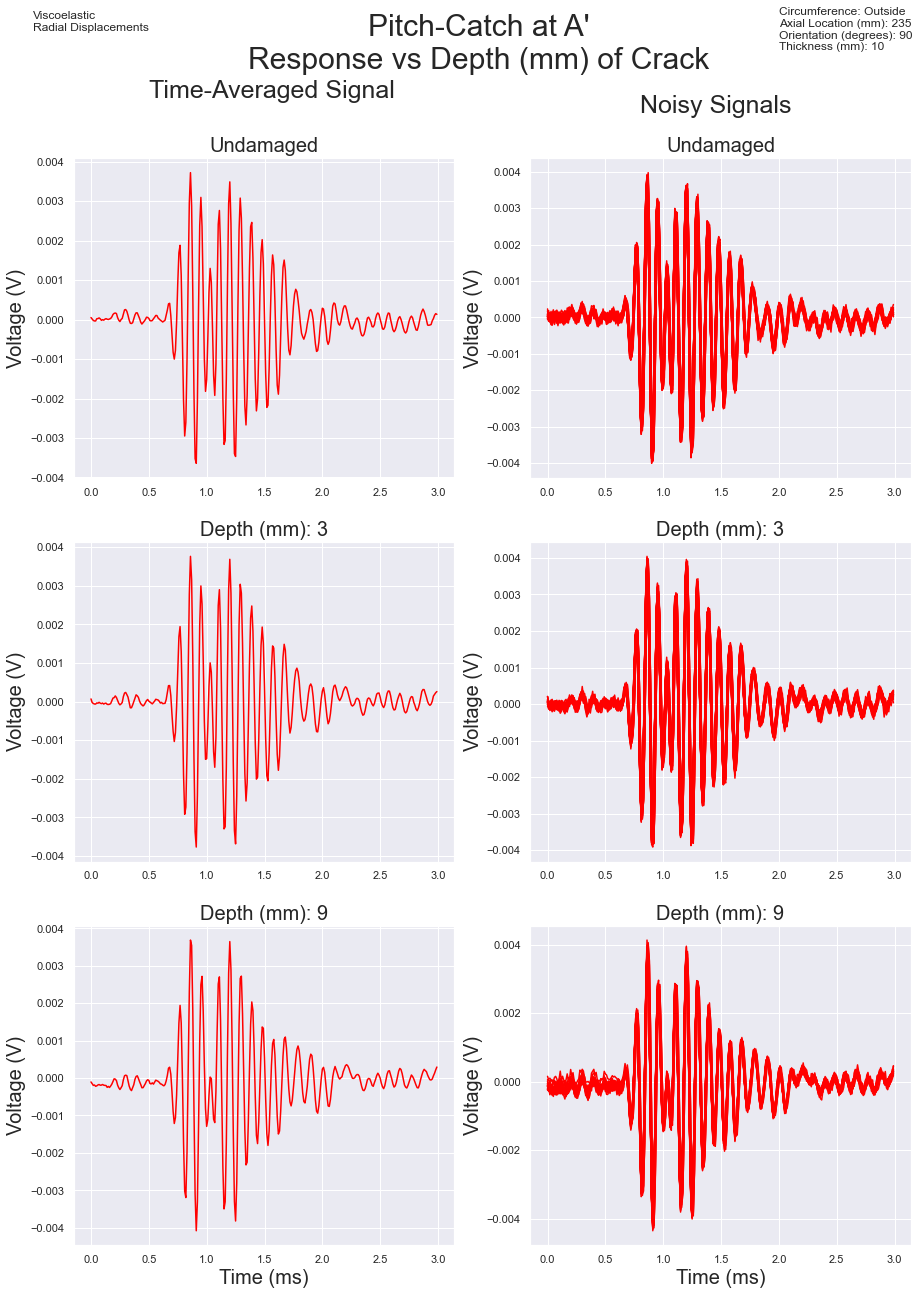

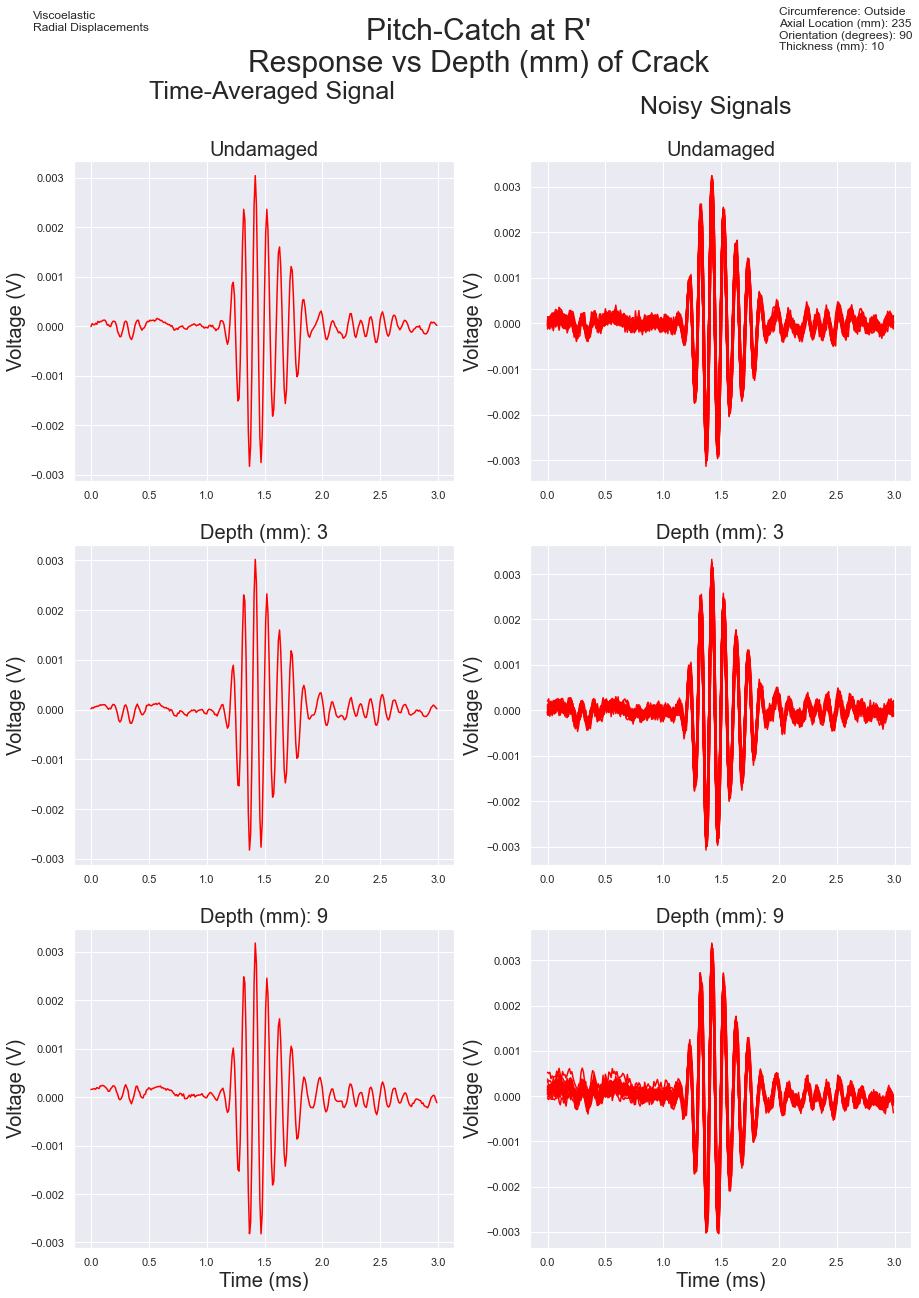

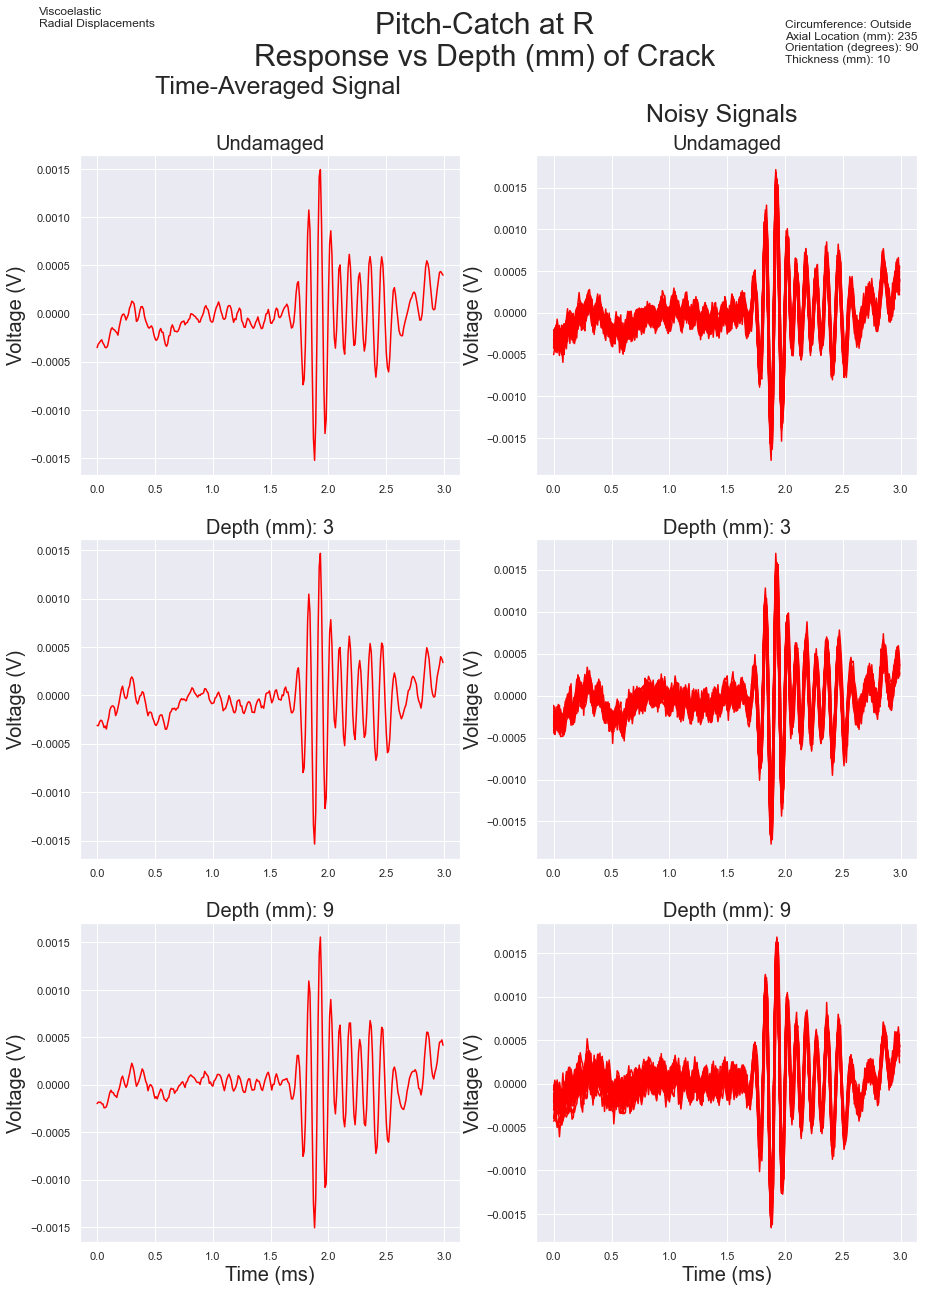

In [115]:
for Array in signals.keys():
    
    if Array == 'A':
        Configuration = 'Pulse-Echo'
    else:
        Configuration = 'Pitch-Catch'
    
    fig, ax = plt.subplots(no_ds, 2, figsize = (15,20))
    i = 0
    
    while i < no_ds:
        state = states[i]
        j = 0;
        subtitle = '';
        
        while j < no_axes:
            axis = axes[j];

            is_state = averaged_signals[Array]['Crack Properties',variable] == states[i];
            is_axis  = averaged_signals[Array]['Transducer','Axis'] == 2.0;
            signal   = averaged_signals[Array][is_state & is_axis];

            signal_time = signal['Time Domain (ms)'];
            
            if Configuration == 'Pulse-Echo':
                ax[i][0].set_ylim([-0.01, 0.01])
            
            if np.nan in signal_time:
                continue

            max_value = signal_time.to_numpy().max()
            
            ax[i][0].plot(time.transpose(),signal_time.to_numpy().transpose() ,color = colors[j], label = 'Axis ' + str(Axes[j]));
            ax[i][0].set_ylabel('Voltage (V)', fontsize = 20)
            ax[i][0].grid(visible = True, which = 'major')

            j = j + 1;
            
        j = 0

        while j < no_axes:
            axis = axes[j];

            is_state = signals[Array]['Crack Properties',variable] == states[i];
            is_axis  = signals[Array]['Transducer','Axis'] == 2.0;
            signal   = signals[Array][is_state & is_axis];

            signal_time = signal['Time Domain (ms)'];
            
            if Configuration == 'Pulse-Echo':
                ax[i][1].set_ylim([-0.01, 0.01])
            
            if np.nan in signal_time:
                continue

            max_value = signal_time.to_numpy().max()
            
            ax[i][1].plot(time.transpose(),signal_time.to_numpy().transpose() ,color = colors[j], label = 'Axis ' + str(Axes[j]));
            ax[i][1].set_ylabel('Voltage (V)', fontsize = 20)

            j = j + 1;

        if i == 0:
            subtitle = 'Undamaged'
        else:
            subtitle = variable + ': ' + str(states[i])
        ax[i][0].set_title(subtitle, fontsize = 20)
        ax[i][1].set_title(subtitle, fontsize = 20)
            
        i = i + 1;

    ax[-1][0].set_xlabel('Time (ms)', fontsize = 20)
    ax[-1][1].set_xlabel('Time (ms)', fontsize = 20)
    
    if Configuration == 'Pulse-Echo':
        textyloc = 0.015;
    else:
        textyloc = max_value*1.7;

    ax[0][0].text(-0.5, textyloc, parameters, fontsize=12)
    ax[0][-1].text(2.0, textyloc, crack_props, fontsize=12)
    
    ax[0][0].text(0.5, 0.8*textyloc, 'Time-Averaged Signal', fontsize = 25)
    ax[0][1].text(0.8, 0.8*textyloc, 'Noisy Signals', fontsize = 25)

    fig.suptitle(Configuration + ' at '+ Array +'\nResponse vs ' + variable + ' of Crack',fontsize = 30)

    fig.savefig(Array + ' ' + savename,dpi = 250)
    

In [116]:
savename = Pipe_physical + ' Noisy Amplitude Spectrum '
savename += '.png'
savename

'Pipe 4 Noisy Amplitude Spectrum .png'

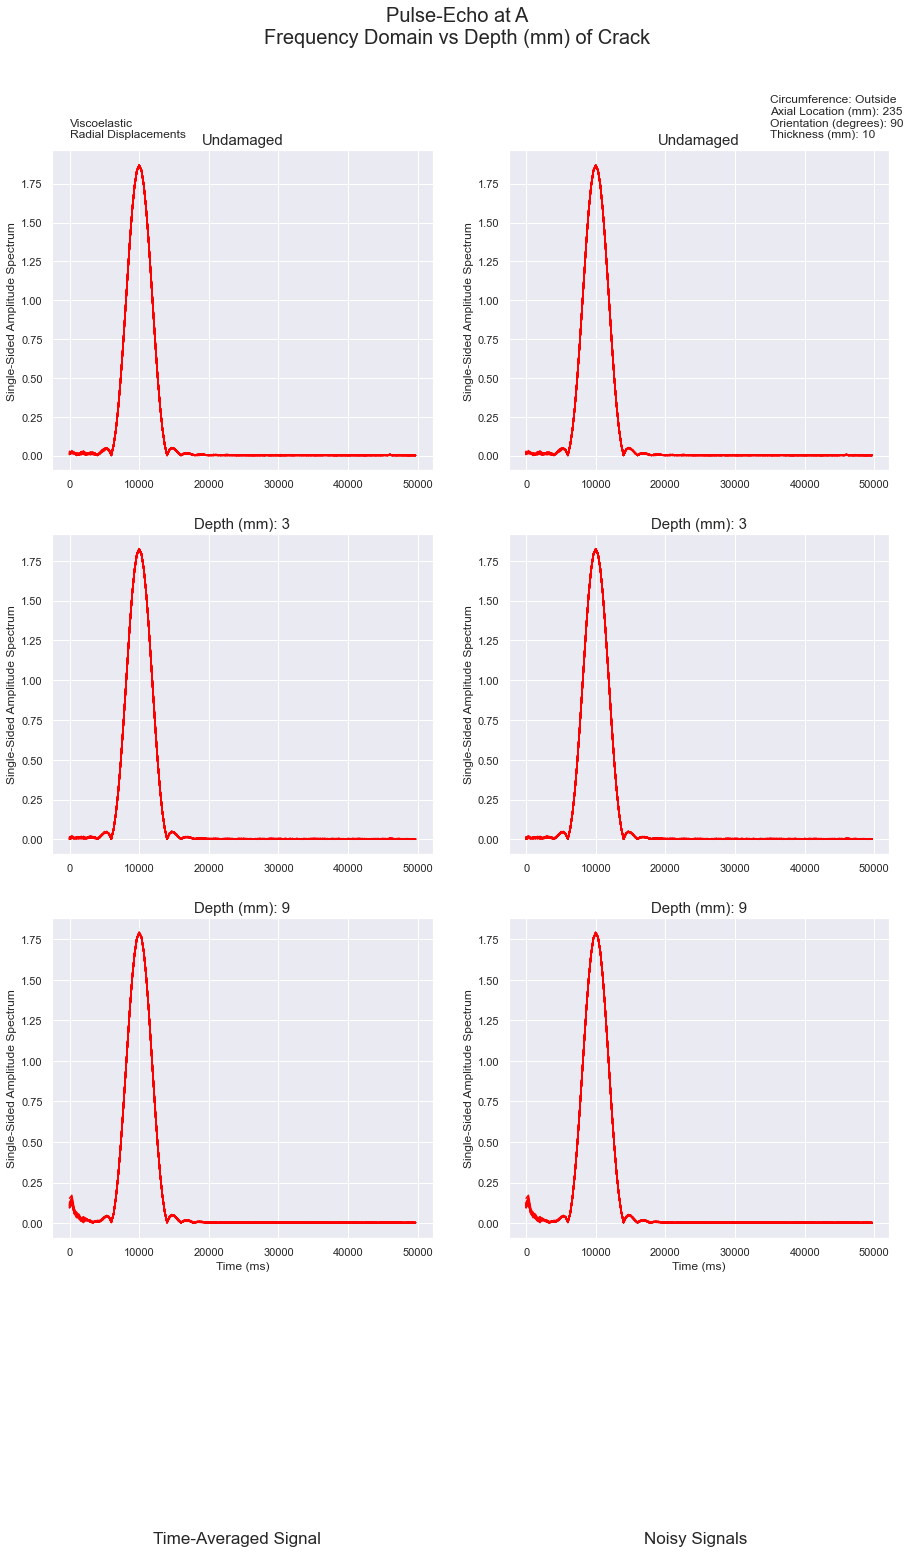

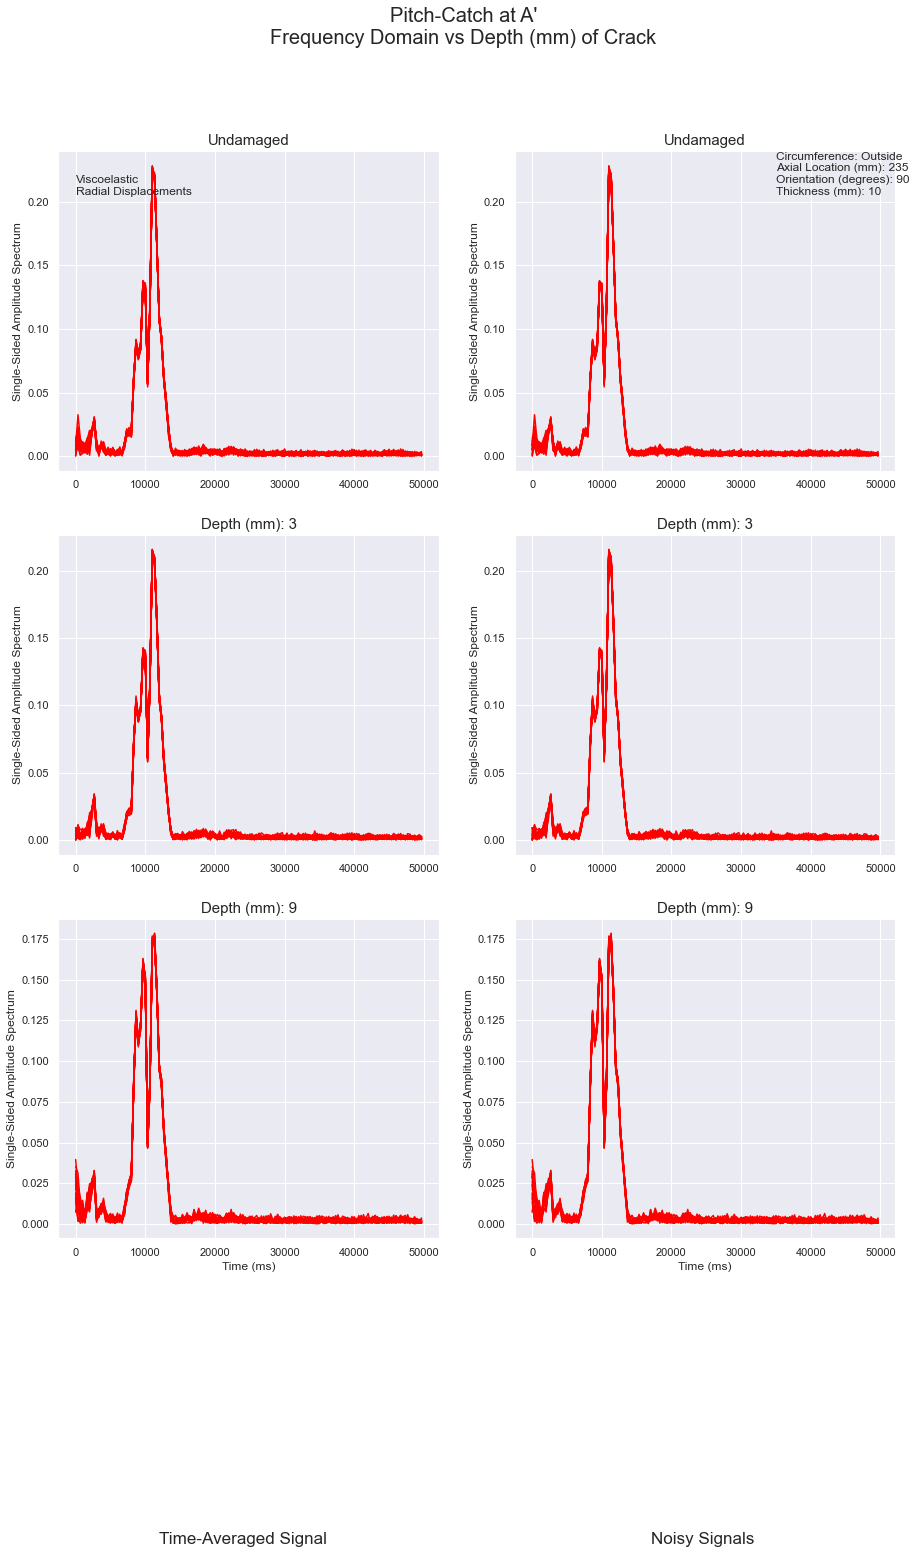

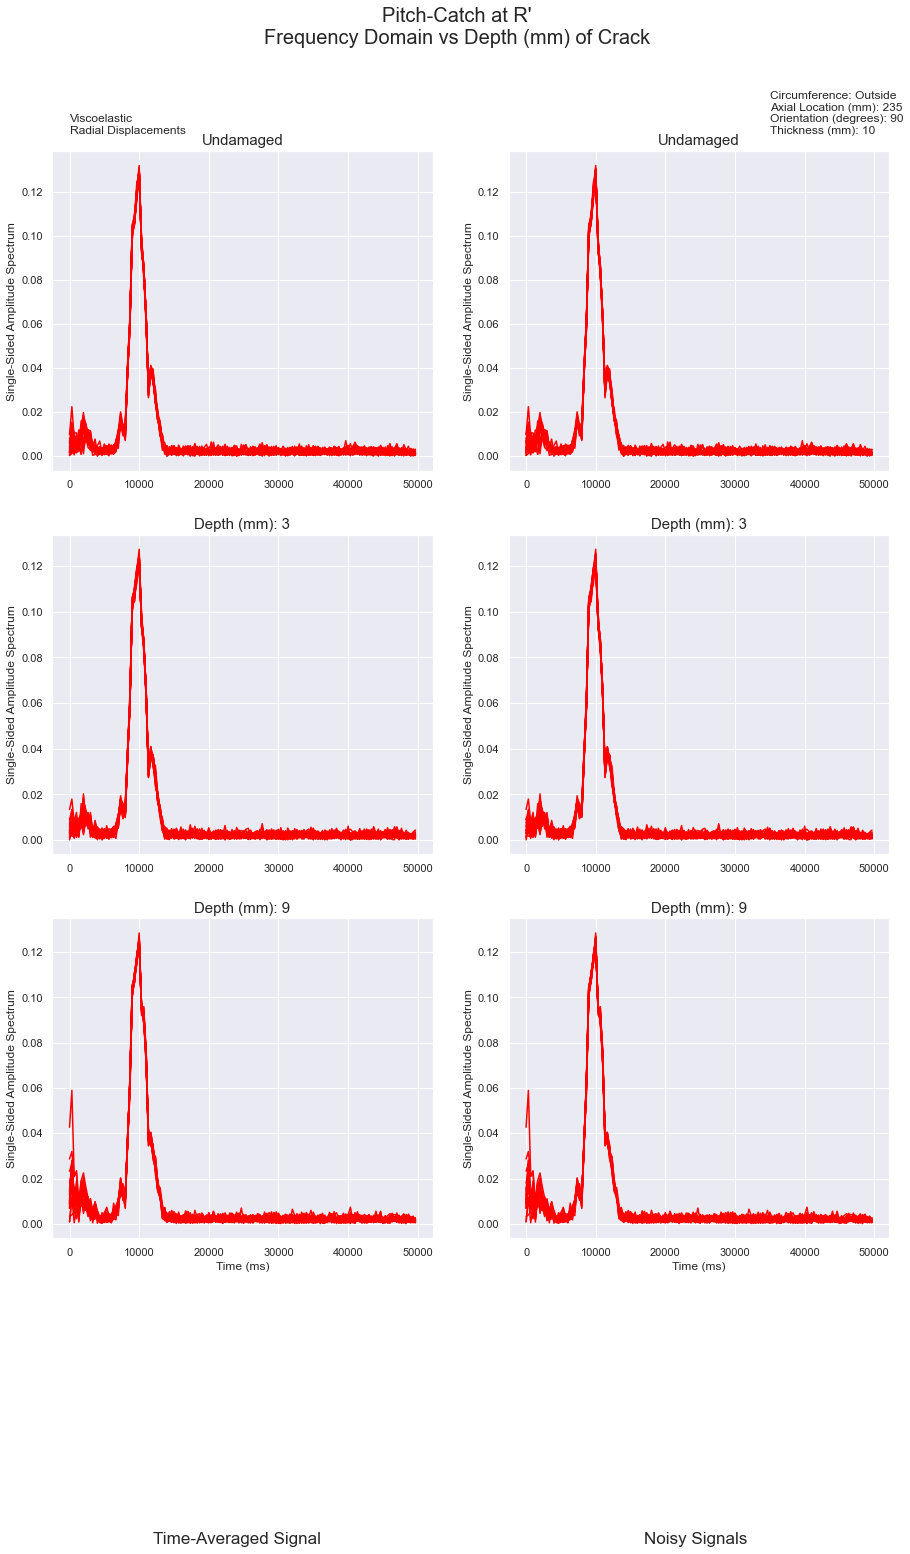

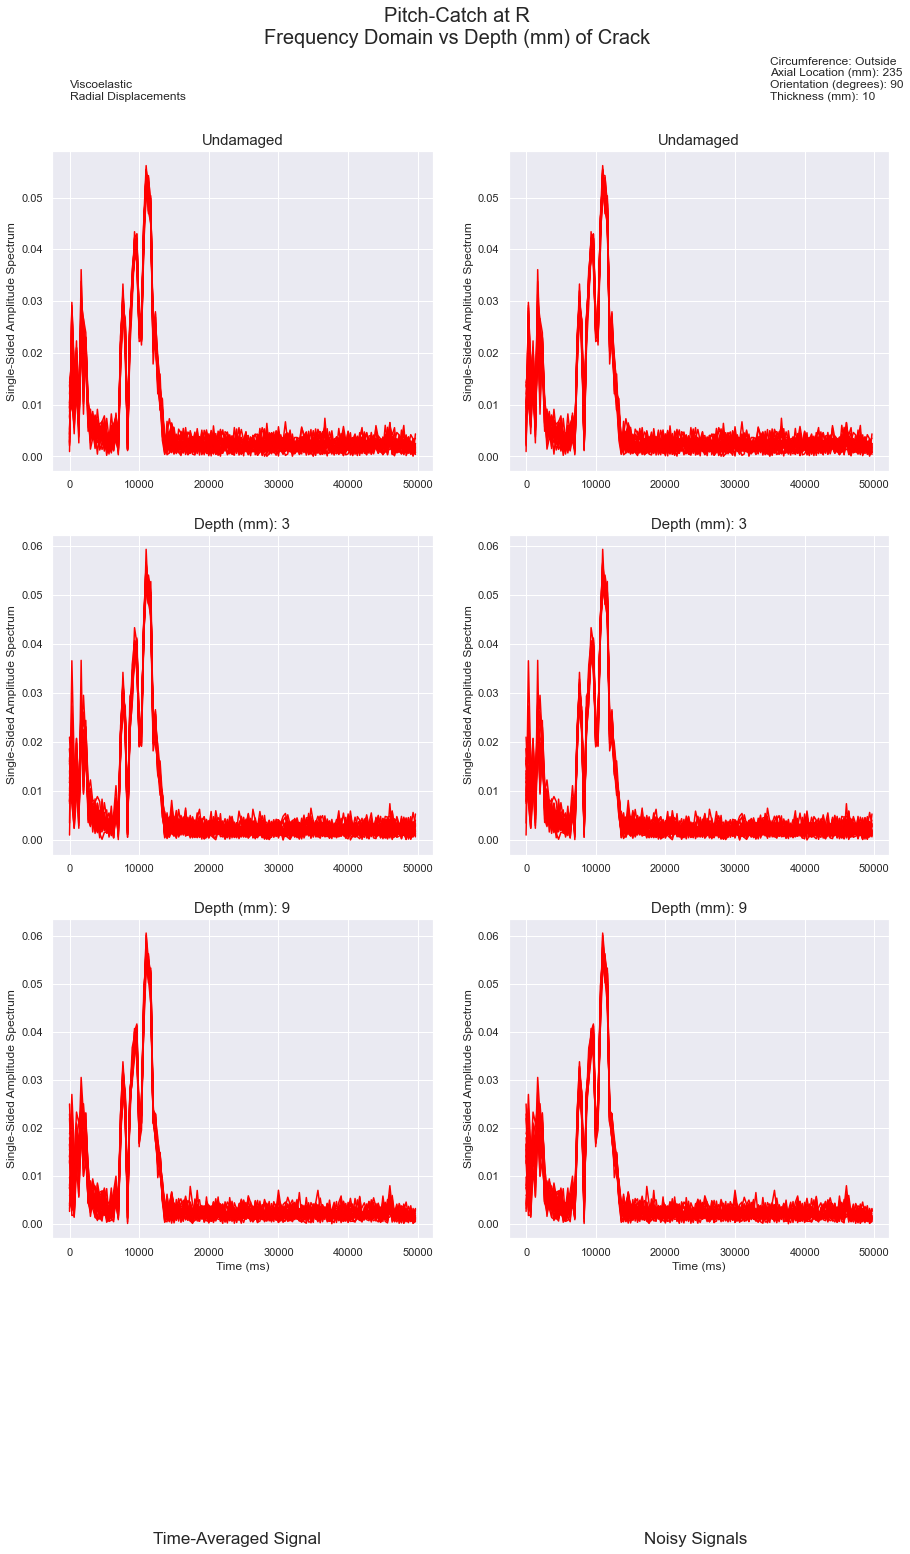

In [117]:
for Array in signals.keys():
    
    if Array == 'A':
        Configuration = 'Pulse-Echo'
    else:
        Configuration = 'Pitch-Catch'
    
    fig, ax = plt.subplots(no_ds, 2, figsize = (15,20))
    i = 0
    
    while i < no_ds:
        state = states[i]
        j = 0;
        subtitle = '';
        
        while j < no_axes:
            axis = axes[j];

            is_state = signals[Array]['Crack Properties',variable] == states[i];
            is_axis  = signals[Array]['Transducer','Axis'] == 2;
            signal   = signals[Array][is_state & is_axis];

            signal_freq = signal['Frequency Domain (Hz)'];
            
            if np.nan in signal_freq:
                continue

            max_value = signal_freq.to_numpy().max()
            
            ax[i][0].plot(signal_freq.columns,signal_freq.to_numpy().transpose() ,color = colors[j], label = 'Axis ' + str(Axes[j]));
            ax[i][0].set_ylabel('Single-Sided Amplitude Spectrum', fontsize = 12)

            j = j + 1;
            
        j = 0

        while j < no_axes:
            axis = axes[j];

            is_state = averaged_signals[Array]['Crack Properties',variable] == states[i];
            is_axis  = averaged_signals[Array]['Transducer','Axis'] == 2;
            signal   = averaged_signals[Array][is_state & is_axis];

            signal_ferq = signal['Frequency Domain (Hz)'];
            
            if np.nan in signal_freq:
                continue

            max_value = signal_freq.to_numpy().max()
            
            ax[i][1].plot(signal_freq.columns,signal_freq.to_numpy().transpose() ,color = colors[j], label = 'Axis ' + str(Axes[j]));
            ax[i][1].set_ylabel('Single-Sided Amplitude Spectrum', fontsize = 12)

            j = j + 1;

        if i == 0:
            subtitle = 'Undamaged'
        else:
            subtitle = variable + ': ' + str(states[i])
        ax[i][0].set_title(subtitle, fontsize = 15)
        ax[i][1].set_title(subtitle, fontsize = 15)
            
        i = i + 1;

    ax[-1][0].set_xlabel('Time (ms)', fontsize = 12)
    ax[-1][1].set_xlabel('Time (ms)', fontsize = 12)
    
    textyloc = max_value*1.1;

    ax[0][0].text(0, textyloc, parameters, fontsize=12)
    ax[0][-1].text(35000, textyloc, crack_props, fontsize=12)
    
    ax[-1][0].text(12000, -1*textyloc, 'Time-Averaged Signal', fontsize = 17)
    ax[-1][1].text(17000, -1*textyloc, 'Noisy Signals', fontsize = 17)

    fig.suptitle(Configuration + ' at '+ Array +'\nFrequency Domain vs ' + variable + ' of Crack',fontsize = 20)

    fig.savefig(Array + ' ' + savename,dpi = 250)

### DWT Spectrogram

The discrete wavelet transform is an operation by which a mother wavelet (Daubacheis 1 in this case) is dilated and shifted across the domain of the signal in order to reconstruct it in a number of different frequencies. 

In [120]:
coeffs = pywt.wavedec(signal_time, 'db1', mode = 'sym', level = 5); # DWT
cA5, cD5, cD4, cD3, cD2, cD1 = coeffs

In [121]:
no_coeffs = 6;

In [124]:
savename = Pipe_physical + ' DWT ' + Elasticity + ' ' + disps 
savename += '.png'
savename

'Pipe 4 DWT Viscoelastic Radial Displacements.png'

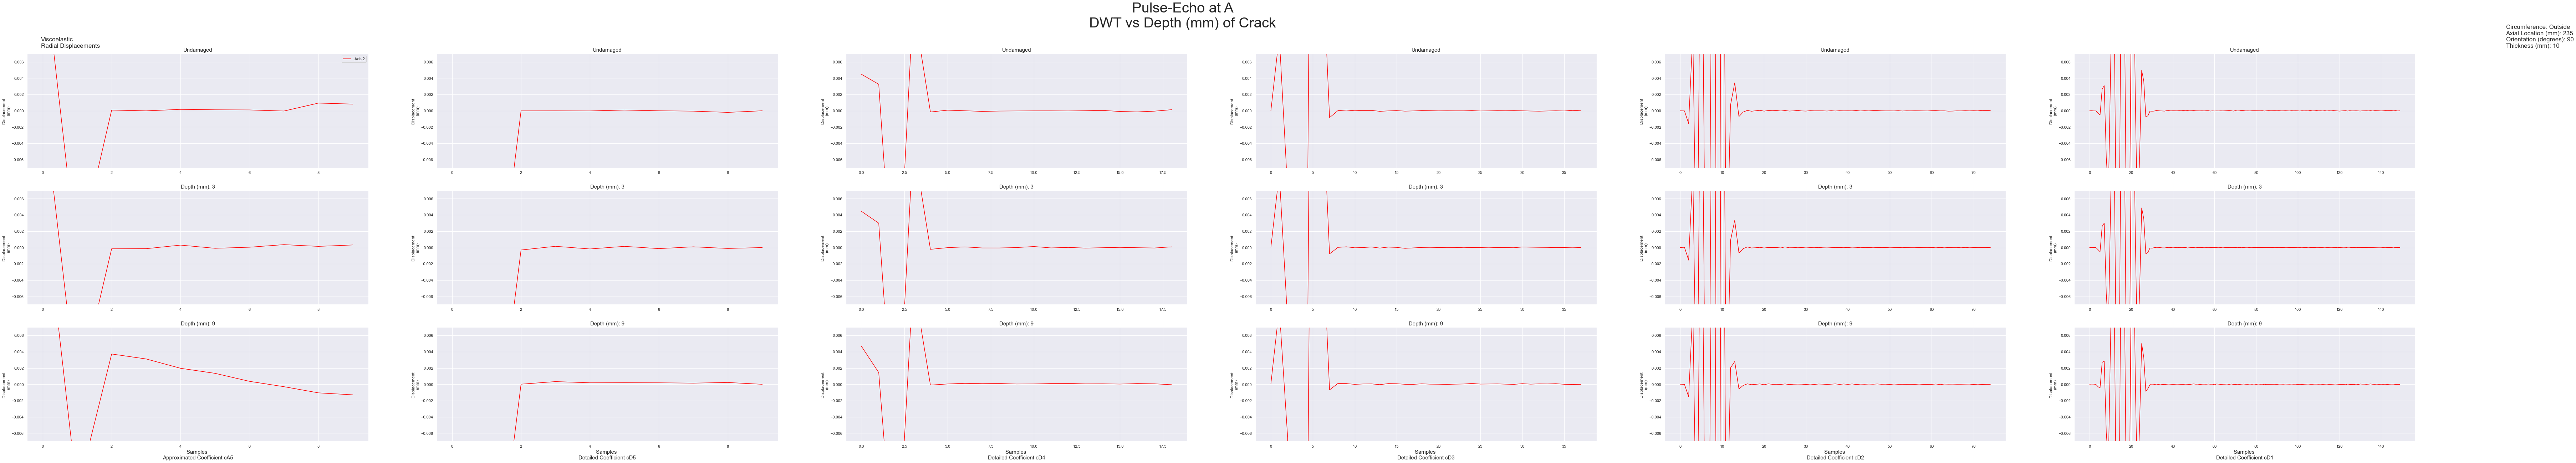

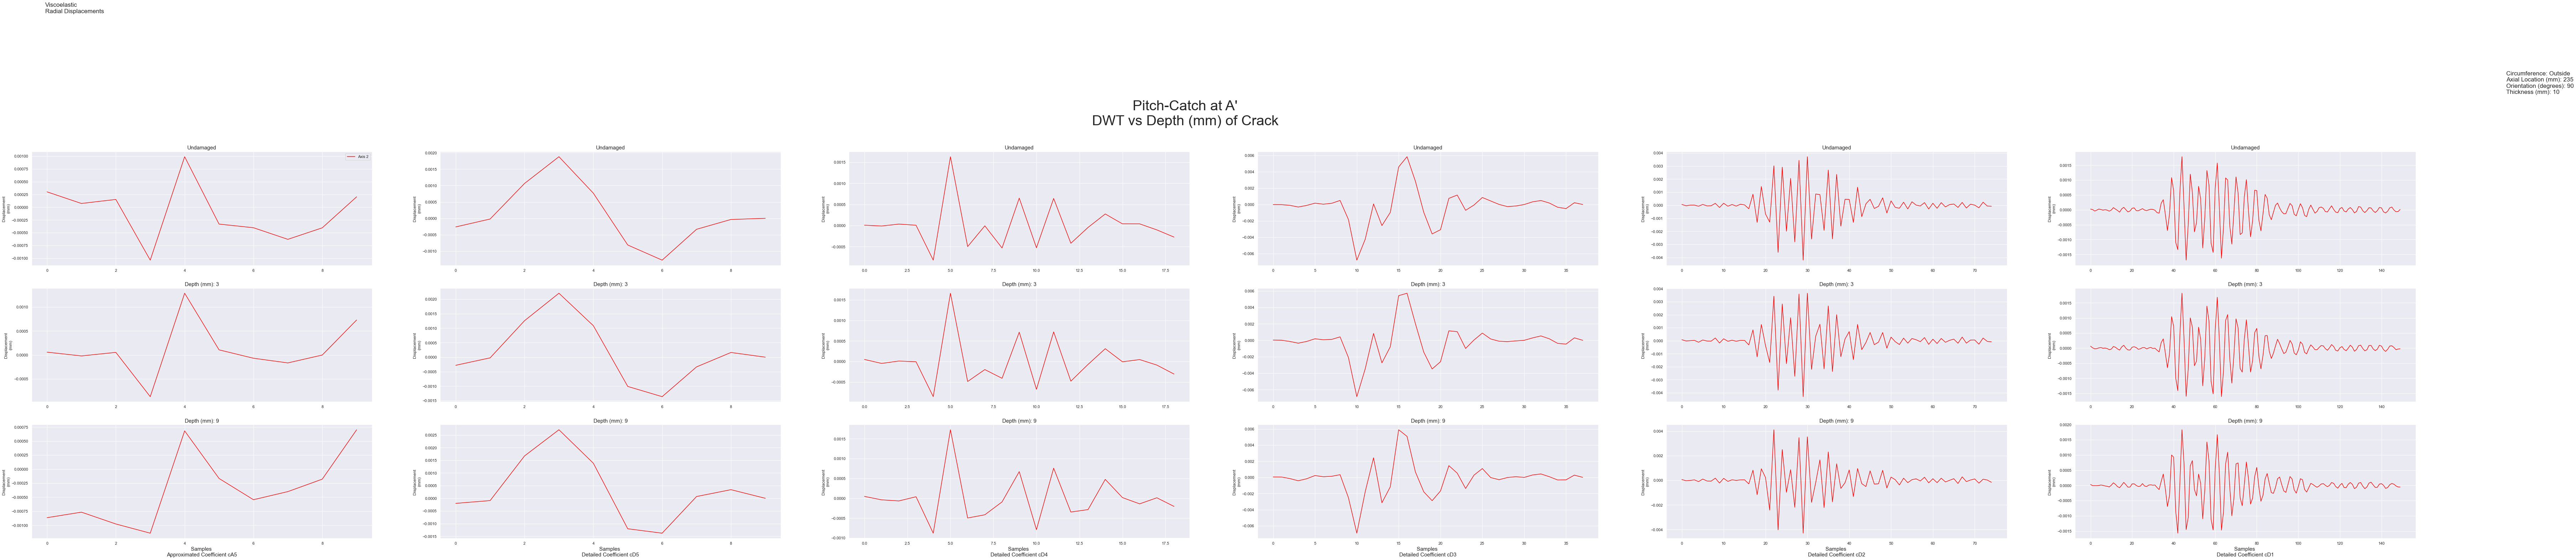

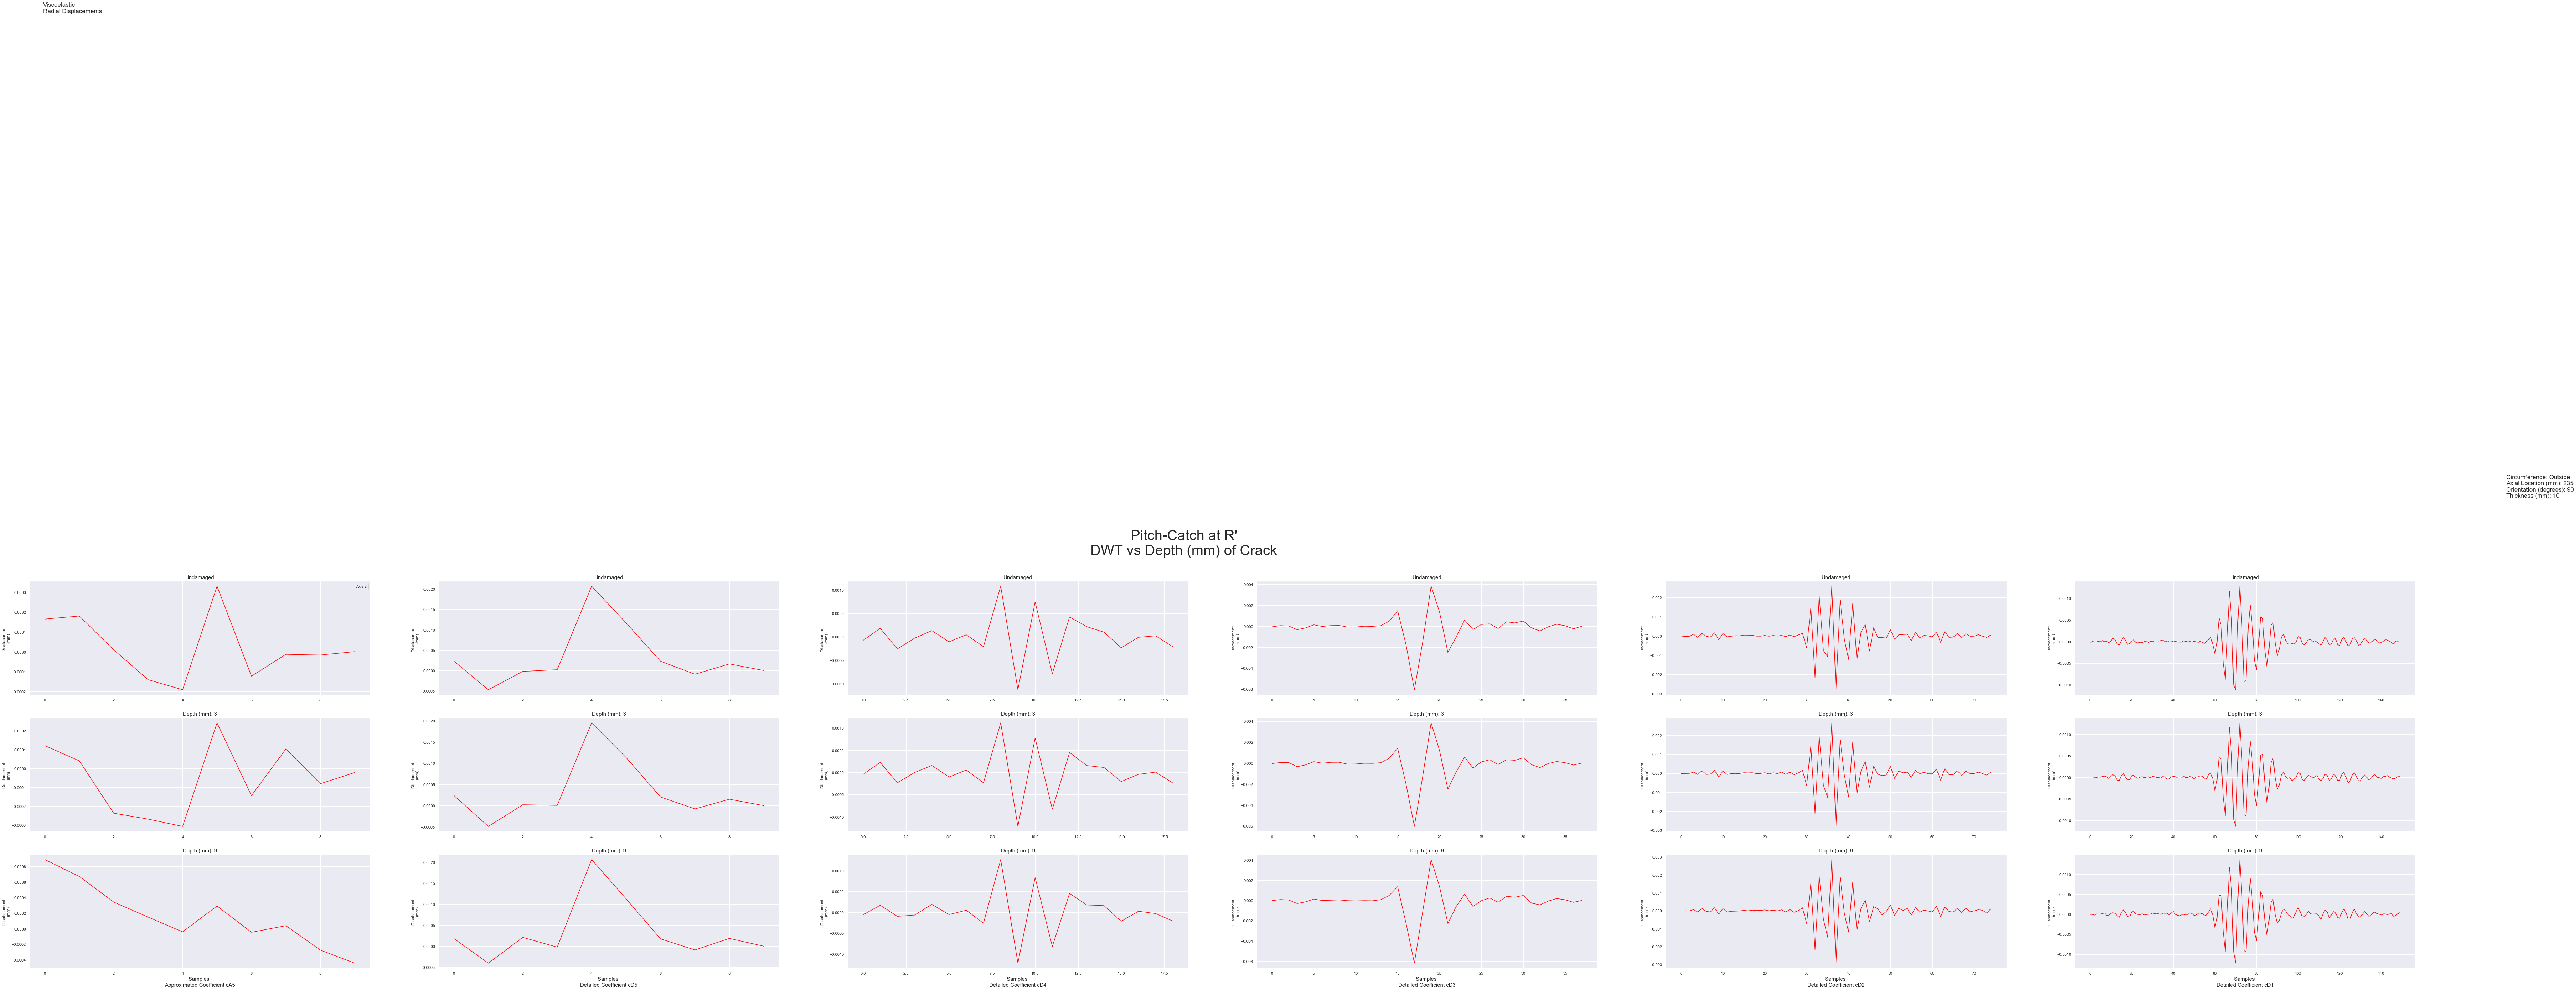

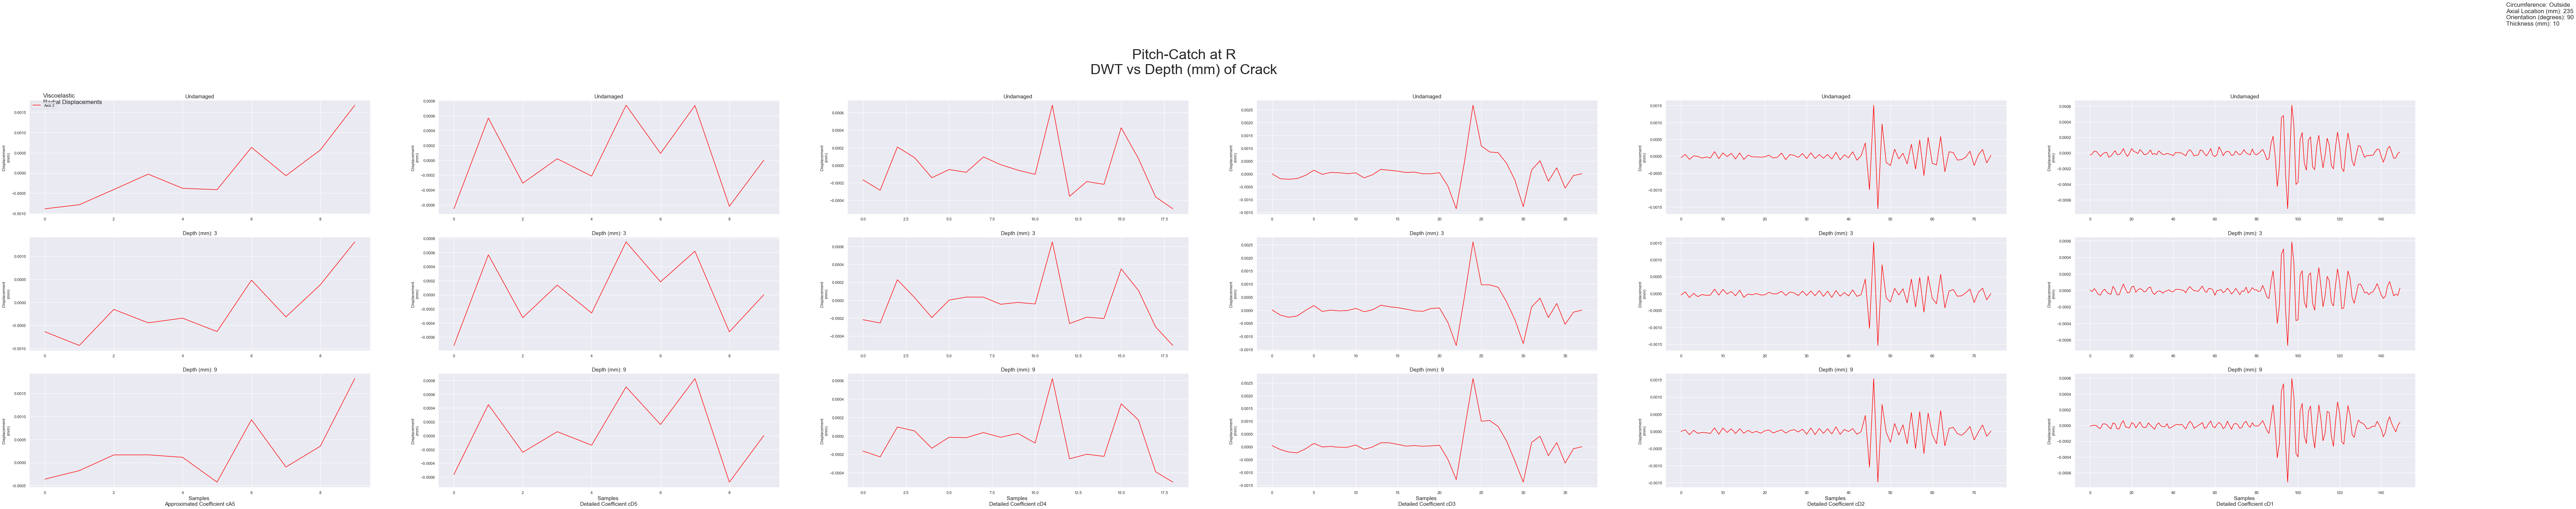

In [127]:
for Array in averaged_signals.keys():
    
    if Array == 'A':
        Configuration = 'Pulse-Echo'
    else:
        Configuration = 'Pitch-Catch'
    
    fig, ax = plt.subplots(no_ds, no_coeffs, figsize = (120,20))
    i = 0
    
    while i < no_ds:
        state = states[i]
        j = 0;
        subtitle = '';

        while j < no_axes:
            axis = axes[j];

            is_state = averaged_signals[Array]['Crack Properties',variable] == states[i];
            is_axis  = averaged_signals[Array]['Transducer','Axis'] == 2;
            signal   = averaged_signals[Array][is_state & is_axis];

            signal_time = signal['Time Domain (ms)'];
            
            if np.nan in signal_time:
                continue

            max_value = signal_time.to_numpy().max()
            
            coeffs = pywt.wavedec(signal_time, 'db1', mode = 'sym', level = 5); # DWT
            cA5, cD5, cD4, cD3, cD2, cD1 = coeffs
            
            k = 0
            for coeff in coeffs:
                
                if Configuration == 'Pulse-Echo':
                    ax[i][k].set_ylim([-0.007, 0.007])
                
                samples = np.arange(0,len(coeff.transpose()))
                ax[i][k].plot(samples,coeff.transpose() ,color = colors[j], label = 'Axis ' + str(Axes[j]));
                ax[i][k].set_ylabel('Displacement \n(mm)', fontsize = 12)
                                
                if i == 0:
                    subtitle = 'Undamaged'
                else:
                    subtitle = variable + ': ' + str(states[i])
                ax[i][k].set_title(subtitle, fontsize = 15)

                k = k + 1;

            j = j + 1;
            
        i = i + 1;


    ax[0][0].legend(loc = 'best', ncol = 1)
    
    if Configuration == 'Pulse-Echo':
        textyloc = 0.007;
    else:
        textyloc = max_value;

    ax[-1][0].set_xlabel('Samples \nApproximated Coefficient cA5', fontsize = 15)
    ax[-1][1].set_xlabel('Samples \nDetailed Coefficient cD5', fontsize = 15)
    ax[-1][2].set_xlabel('Samples \nDetailed Coefficient cD4', fontsize = 15)
    ax[-1][3].set_xlabel('Samples \nDetailed Coefficient cD3', fontsize = 15)
    ax[-1][4].set_xlabel('Samples \nDetailed Coefficient cD2', fontsize = 15)
    ax[-1][5].set_xlabel('Samples \nDetailed Coefficient cD1', fontsize = 15)
        
    ax[0][0].text(-0.05, textyloc, parameters, fontsize=17)
    ax[0][-1].text(200, textyloc, crack_props, fontsize=17)

    fig.suptitle(Configuration + ' at '+ Array +'\nDWT vs ' + variable + ' of Crack',fontsize = 40)

    # fig.savefig(Array + ' ' + savename,dpi = 250)

## Machine Learning

Objective: Classify the noisy damage data via the amplitude of the frequency. 

Begin by zeroing in on only the frequencies which best describe teh signal. For our purposes, this will be the frequencies between 7,000 Hz and 13,000 Hz.

In [128]:
imp_freqs = []
for freq in list(P1['Frequency Domain (Hz)'].columns):
    if (freq >= 7000):
        if (freq <= 12000):
            imp_freqs.append(freq)

Define the color markers for each damaged state

In [129]:
colors_index = [0] * 10 
colors_index[0:len(states)] = states
colors = {colors_index[0]:'black', 
          colors_index[1]:'blue', 
          colors_index[2]:'green', 
          colors_index[3]:'purple', 
          colors_index[4]:'red', 
          colors_index[5]:'magenta', 
          colors_index[6]:'cyan', 
          colors_index[7]:'black'}

colors

{0: 'black', 3: 'blue', 9: 'green'}

Plot all frequency domains on one graph per transducer array. Color-code them by damaged state. We're examining Axis 2, the axis with the crack.

Run a preliminary PCA analysis on the frequency domains to transform the data to a 2-PC space. Obtain the amount of variance from the original dataset explained by the principal components.

Finally, plot the transducer frequency response on the transformed plane. Because the variance is explained concisely with just two principal components, it should be much easier to cluster the damaged states on the transformed plane. 

In [130]:
max(max_signals['R']['Frequency Domain (Hz)'].max())

0.060622899803169254

In [131]:
savename1 = Pipe_physical + ' Damaged State as a Function of Frequency Variables '
savename1 += '.png'
savename1

savename2 = Pipe_physical + ' Preliminary PCA '
savename2 += '.png'
savename2

savename3 = Pipe_physical + ' Damaged State as a Function of Principal Components '
savename3 += '.png'
savename3

'Pipe 4 Damaged State as a Function of Principal Components .png'

In [132]:
colors.keys()

dict_keys([0, 3, 9])

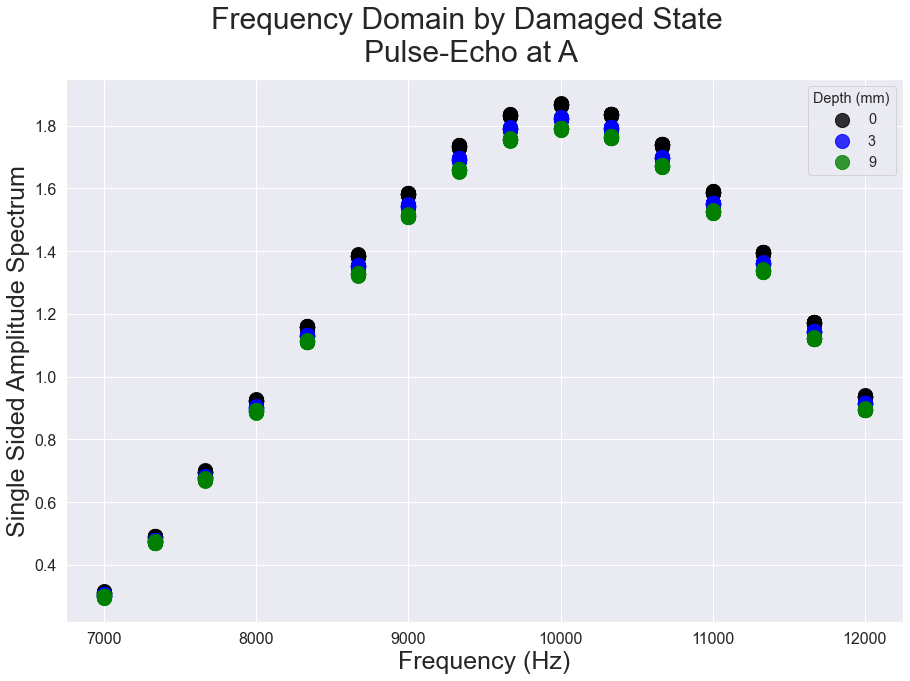

original shape:    (69, 16)
transformed shape: (69, 2)
Variance explained by each principal component 
PC1: 0.9921341378999523 
PC2: 0.0022184463541425723


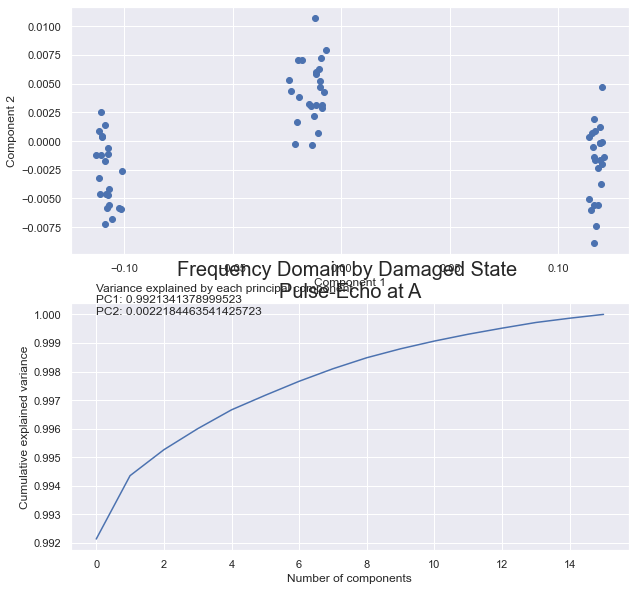

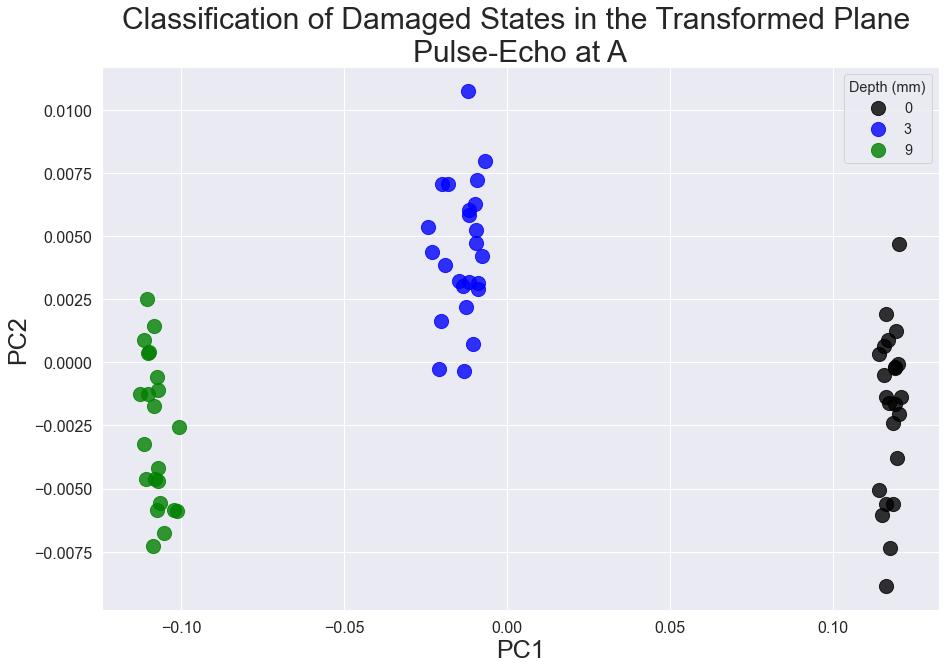

Pulse-Echo at A
Number of Principal Components = 1
Accuracy of Classification = 100.0%
Accuracy List = 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0


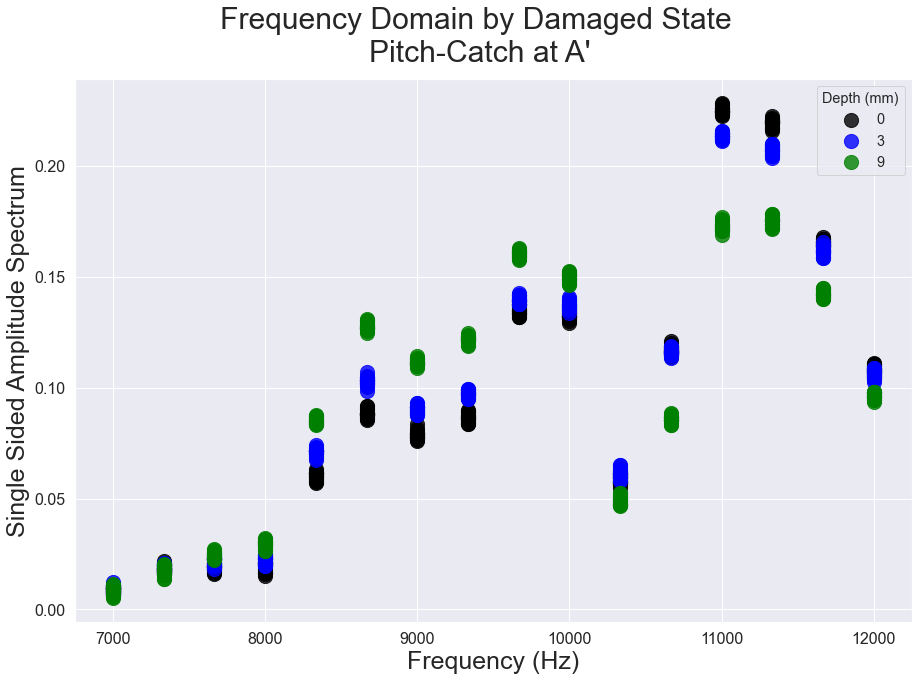

original shape:    (69, 16)
transformed shape: (69, 2)
Variance explained by each principal component 
PC1: 0.9686424297629765 
PC2: 0.014975420404593107


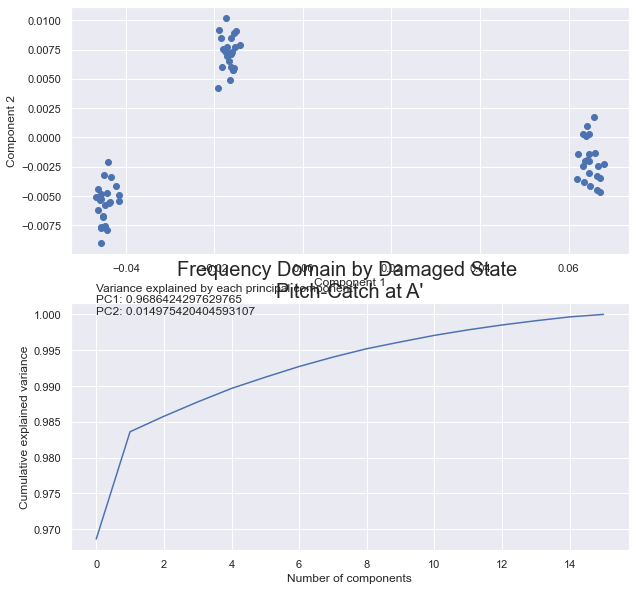

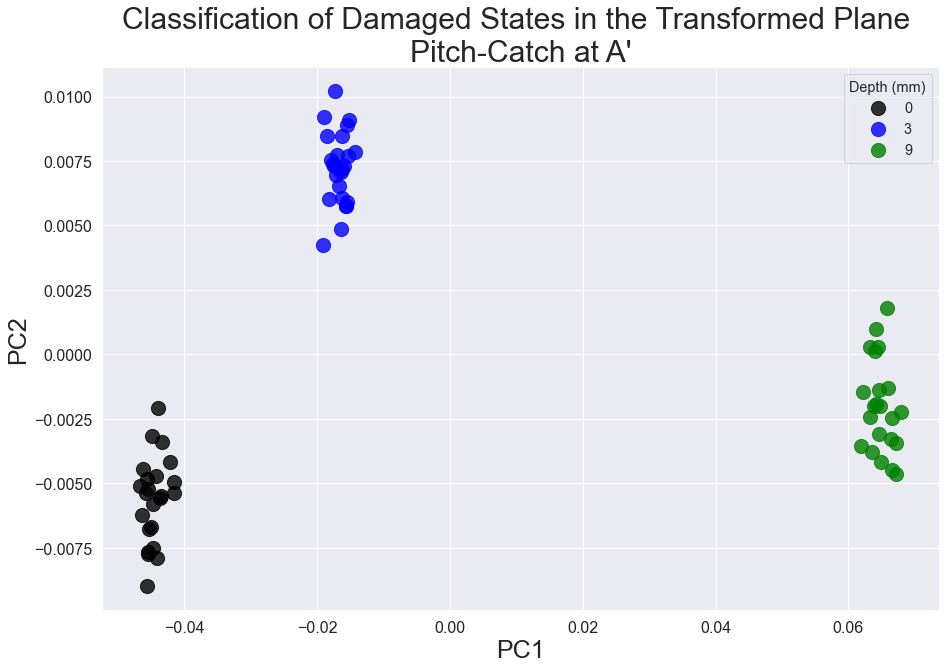

Pitch-Catch at A'
Number of Principal Components = 1
Accuracy of Classification = 100.0%
Accuracy List = 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0


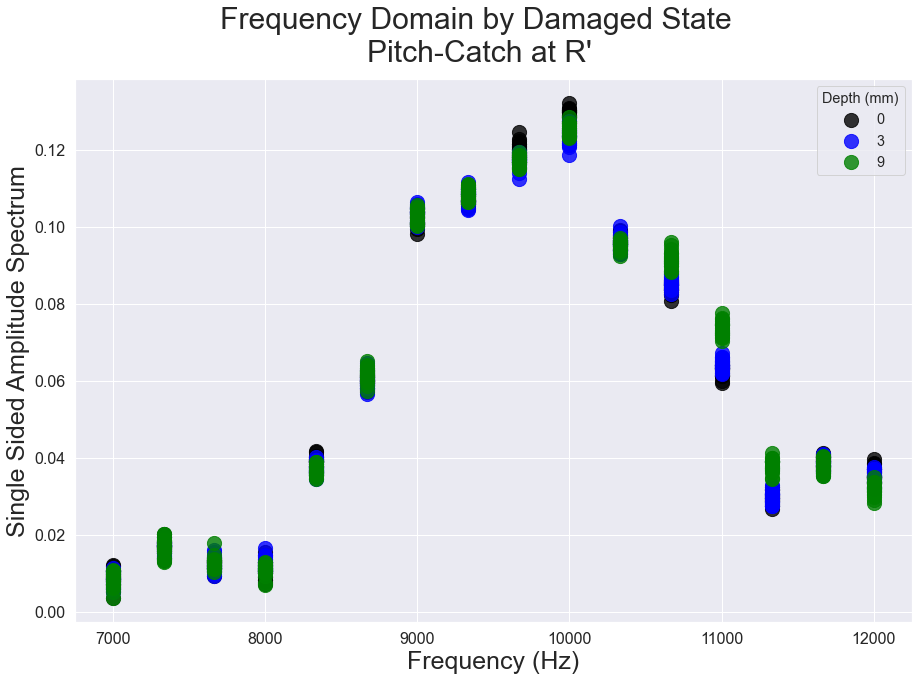

original shape:    (69, 16)
transformed shape: (69, 2)
Variance explained by each principal component 
PC1: 0.5456353373019412 
PC2: 0.10633499586271732


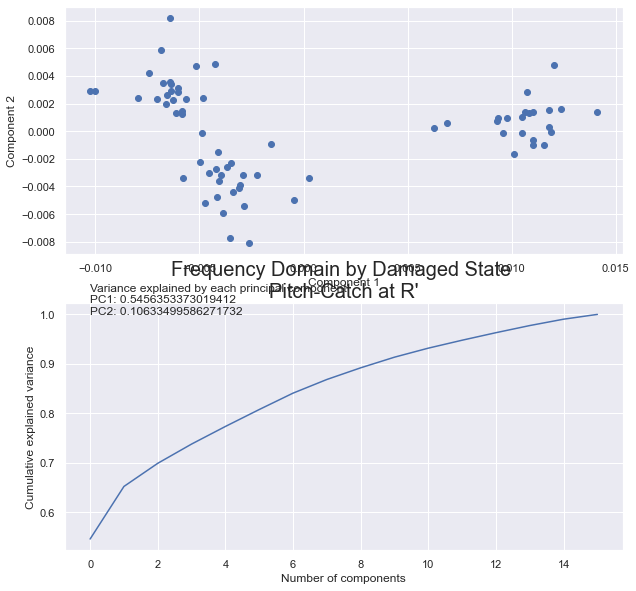

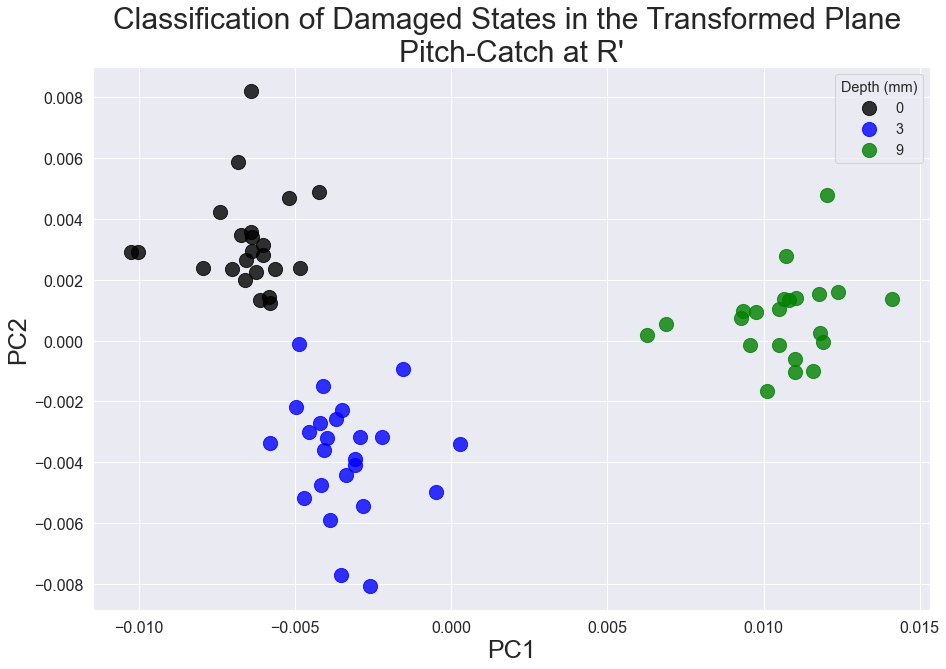

Pitch-Catch at R'
Number of Principal Components = 1
Accuracy of Classification = 100.0%
Accuracy List = 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0


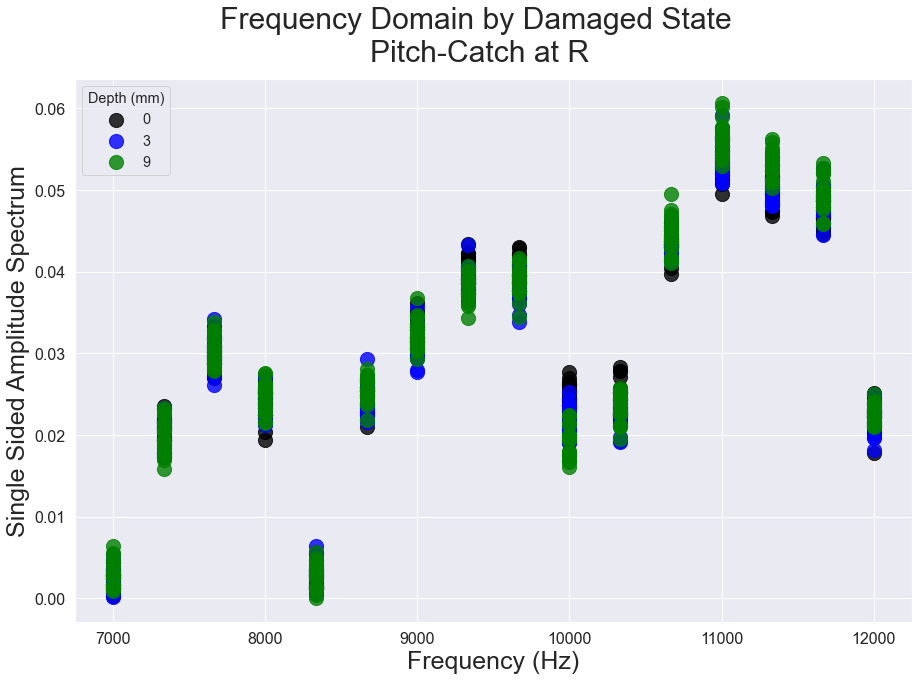

original shape:    (69, 16)
transformed shape: (69, 2)
Variance explained by each principal component 
PC1: 0.25020654604109377 
PC2: 0.10610197639019052


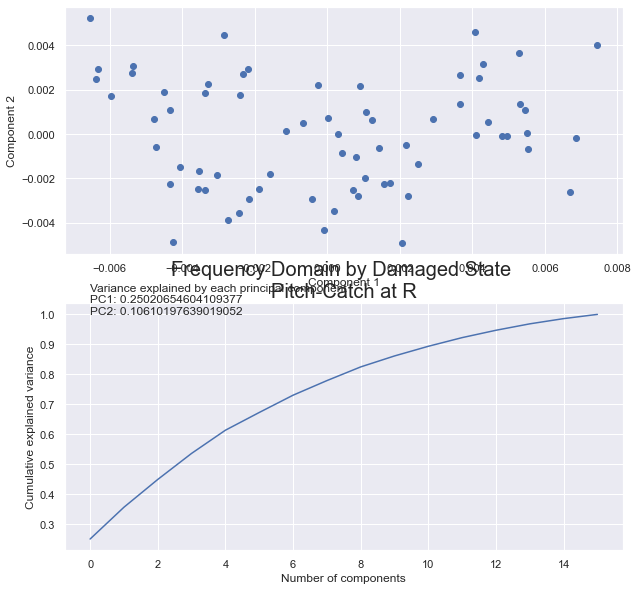

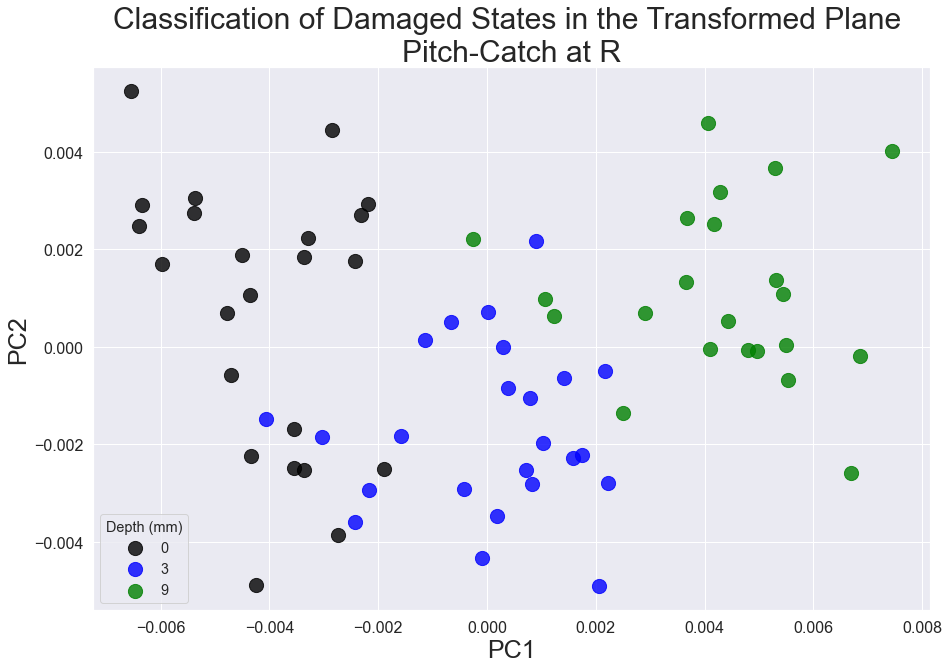

Pitch-Catch at R
Number of Principal Components = 10
Accuracy of Classification = 94.39999999999999%
Accuracy List = 0.7222222222222222, 0.7222222222222222, 0.7777777777777778, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8333333333333334, 0.8333333333333334, 0.9444444444444444, 0.8888888888888888, 0.8888888888888888


In [133]:
for Array in signals.keys():
    
    if Array == 'A':
        Configuration = 'Pulse-Echo'
    else:
        Configuration = 'Pitch-Catch'

    is_axis        = signals[Array]['Transducer','Axis'] == 2;
    interest_freqs = signals[Array][is_axis]['Frequency Domain (Hz)'][imp_freqs]
    interest_freqs[variable] = signals[Array][is_axis]['Crack Properties', variable]

    states = interest_freqs[variable].unique()
    
    # Plot the frequency domains
    fig, ax = plt.subplots(figsize = (15,10))
    
    max_value = max(max_signals[Array]['Frequency Domain (Hz)'].max())

    for freq in imp_freqs:
        for state in states:
            c = colors[state]
            x1 = np.ones(len(interest_freqs[interest_freqs[variable] == state][freq].index));
            x1 = x1*freq;
            plt.scatter(x = x1, y = interest_freqs[interest_freqs[variable] == state][freq], alpha = 0.8, color = c, s = 200)
            
    # ax.text(imp_freqs[0], max_value*1.2, parameters, fontsize=17)
    # ax.text(imp_freqs[0]+(imp_freqs[-1]-imp_freqs[0])*5/6, max_value*1.2, crack_props, fontsize=17)
    
    plt.legend(states, title = variable, loc = 'best', fancybox = True, fontsize = 'large', title_fontsize = 'large');
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(16)    
    plt.ylabel('Single Sided Amplitude Spectrum', fontsize = 25)
    plt.xlabel('Frequency (Hz)', fontsize = 25)    
    fig.suptitle('Frequency Domain by Damaged State \n' + Configuration + ' at ' + Array, fontsize = 30)
    plt.grid(which='major', linestyle='-')    
    plt.show()
    
    fig.savefig(Array + ' ' + savename1,dpi = 250)
    
    # Plot the preliminary results and cumulative explained variance vs number of PCs
    freq_pca, comps, transformed_freq = prePCA(interest_freqs.drop(variable, axis = 1))
    plt.title('Frequency Domain by Damaged State \n' + Configuration + ' at ' + Array, fontsize = 20)
    plt.grid(which='major', linestyle='-')    
    plt.show()
    
    reduced_dataset = pd.DataFrame(transformed_freq)
    reduced_dataset.columns = ['Principal Component 1', 'Principal Component 2']
    interest_freqs.reset_index(drop=True, inplace=True)
    reduced_dataset.reset_index(drop=True, inplace=True)
    reduced_dataset[variable] = interest_freqs[variable]
    reduced_dataset
    
    # print('Principal Components: '+comps)
    
    fig.savefig(Array + ' ' + savename2,dpi = 250)
    
    # Plot the damage data on the transformed plane and color code them by damaged state
    fig, ax = plt.subplots(figsize = (15,10))

    for state in states:
        x = reduced_dataset[reduced_dataset[variable] == state]['Principal Component 1'];
        y = reduced_dataset[reduced_dataset[variable] == state]['Principal Component 2'];
        c = colors[state];
        plt.scatter(x = x, y = y, alpha = 0.8, color = c, s= 200); 

    plt.legend(colors.keys(), title = variable, loc = 'best', fancybox = True, fontsize = 'large', title_fontsize = 'large');
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(16)    
    plt.ylabel('PC2', fontsize = 25)
    plt.xlabel('PC1', fontsize = 25)    
    plt.title('Classification of Damaged States in the Transformed Plane \n' + Configuration + ' at ' + Array , fontsize = 30)
    plt.grid(which='major', linestyle='-')    
    plt.show()
    
    fig.savefig(Array + ' ' + savename3,dpi = 250)
    
    # Perform an SVM to determine the ideal number of PCs for best accuracy
    scaler = StandardScaler()
    x = scaler.fit_transform(interest_freqs)
    y = interest_freqs[variable]

    Xtrain, Xtest, ytrain, ytest = train_test_split(x, y, random_state=42)

    classification_list = []
    accuracy_list = []
    transformed_data_list = []
    models = {}

    for i in range(1,13):
        classification, accuracy, transformed_data, model = pca_svm(n_components = i)
        classification_list.append(classification)
        accuracy_list.append(accuracy)
        transformed_data_list.append(transformed_data)
        models[i] = model
        
    max_acc = max(accuracy_list)
    num_PCs = accuracy_list.index(max_acc)+1

    max_acc = float("{:.3f}".format(max_acc))
    print(color.BOLD + Configuration + ' at ' + Array + 
          "\nNumber of Principal Components = " + str(num_PCs) +
          '\n' + "Accuracy of Classification = " + str(max_acc*100) + "%"
          '\n' "Accuracy List = " + str(accuracy_list)[1:-1] + color.END)

Get 500 datapoints at least. If you still manage to obtain an accuracy of at least 80%, overfitting has been controlled better